In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ast

In [2]:
path = '../../results/halos_matched_disk_noduplicates.csv'
df = pd.read_csv(path)
df.head()

subhalo_TNG50-1  halo_TNG50-1  Mvir_TNG50-1  halo_TNG50-3  Mvir_TNG50-3  \
0         117251.0             3   3470.526367           3.0   3491.555176   
1         143881.0             4   3142.989746           4.0   3239.478027   
2         167393.0             5   1859.250610           5.0   1816.254150   
3         184932.0             6   3027.909180           6.0   3017.573486   
4         198183.0             7   2737.067871           7.0   2795.508057   

   has_disk  
0         1  
1         1  
2         1  
3         1  
4         1

In [3]:
#Contar el numero de halos con y sin disco
df['has_disk'].value_counts() 

has_disk
1    107
0     60
Name: count, dtype: int64

In [4]:
halos = df.copy()
halos.drop(columns=['halo_TNG50-1','subhalo_TNG50-1'], inplace=True)
#ordenar por el indice de TNG50-3
halos=halos.sort_values('halo_TNG50-3')
halos.reset_index(drop=True, inplace=True)
halos.head()


Mvir_TNG50-1  halo_TNG50-3  Mvir_TNG50-3  has_disk
0   7466.339355           1.0   7462.923340         1
1   5243.999512           2.0   5181.124023         1
2   3470.526367           3.0   3491.555176         1
3   3142.989746           4.0   3239.478027         1
4   1859.250610           5.0   1816.254150         1

In [5]:
#leer archivo history
path = '../../results/halos_history.csv'
history = pd.read_csv(path)

history.head()

halo_id  snap    z  epoch          Mdom          Mvir         Rvir
0        0    99  0.0      0  14868.514825  15079.097656  1082.225708
1        0    67  0.5      1  11816.643740   7356.986328   961.575439
2        1    50  1.0      2   6773.379776   4175.038086   831.712219
3        0    40  1.5      3   5495.054348   2296.211914   694.748718
4        0    33  2.0      4   6318.500934   1773.746460   643.600769

In [6]:
# Encontrar los √≠ndices donde snap == 99 (inicio de cada halo)
mask_z0 = history['snap'] == 99
start_idxs = history.index[mask_z0].tolist()
start_idxs.append(len(history))  # A√±adir el final para el √∫ltimo halo

history_grouped = []
for i in range(len(start_idxs) - 1):
    group = history.iloc[start_idxs[i]:start_idxs[i+1]]
    history_grouped.append({
    'halo_id': np.array(group['halo_id']),
    'snap':   np.array(group['snap']),
    'z':      np.array(group['z']),
    'Mdom':   np.array(group['Mdom']),
    'Mvir':   np.array(group['Mvir']),
    'Rvir':   np.array(group['Rvir']),
})



In [7]:
history_accretion = pd.DataFrame(history_grouped)

In [8]:
# Filtrar history_accretion para mantener solo filas cuyo primer halo_id est√° en halos['halo_TNG50-3']
valid_ids = set(halos['halo_TNG50-3'])
mask = history_accretion['halo_id'].apply(lambda ids: ids[0] in valid_ids)
history_accretion = history_accretion[mask].reset_index(drop=True)

In [9]:
history_accretion['Mvir_ratio'] = history_accretion.apply(lambda row: np.array(row['Mvir']) / row['Mvir'][row['z'] == 0], axis=1)

In [10]:
#columna si tiene disco o no
history_accretion['has_disk'] = history_accretion['halo_id'].apply(lambda ids: halos.loc[halos['halo_TNG50-3'] == ids[0], 'has_disk'].values[0])


### Quitando outliers de la manera mas horrible posible

#### Halos con disco (naranja)

In [11]:
#quitar la de arriba
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (3.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][5])
        IDXS.append(i)

#Encontrar el indice con mayor masa
max_Mvir = max(Mvirs)
max_index = Mvirs.index(max_Mvir)
max_halo = IDXS[max_index]
print(f"El halo con mayor masa en z=3.01 es el √≠ndice {max_halo} con Mvir/Mvir0 = {max_Mvir}")

El halo con mayor masa en z=3.01 es el √≠ndice 164 con Mvir/Mvir0 = 0.6180555212628984


In [12]:
#Eliminar el halo con mayor masa en z=3.01
history_accretion = history_accretion.drop(index=max_halo).reset_index(drop=True)

In [13]:
#quitar la de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el √≠ndice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el √≠ndice 67 con Mvir/Mvir0 = 0.0006967442738602725


In [14]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

In [15]:
#quitar la segunda de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el √≠ndice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el √≠ndice 2 con Mvir/Mvir0 = 0.002689757184748481


In [16]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

#### Halos sin disco (azul)

In [17]:
#limpiar halos que no tienen disco outliers
#quitar la de mas arriba
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 0)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con mayor masa
max_Mvir = max(Mvirs)
max_index = Mvirs.index(max_Mvir)
max_halo = IDXS[max_index]
print(f"El halo con mayor masa en z=4.01 es el √≠ndice {max_halo} con Mvir/Mvir0 = {max_Mvir}")

El halo con mayor masa en z=4.01 es el √≠ndice 161 con Mvir/Mvir0 = 0.36986303379475655


In [18]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=max_halo).reset_index(drop=True)

In [19]:
#limpiar halos que no tienen disco outliers
#quitar la segunda de mas arriba
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 0)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con mayor masa
max_Mvir = max(Mvirs)
max_index = Mvirs.index(max_Mvir)
max_halo = IDXS[max_index]
print(f"El halo con mayor masa en z=4.01 es el √≠ndice {max_halo} con Mvir/Mvir0 = {max_Mvir}")

El halo con mayor masa en z=4.01 es el √≠ndice 147 con Mvir/Mvir0 = 0.32344148385448007


In [20]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=max_halo).reset_index(drop=True)

In [21]:
#limpiar halos que no tienen disco outliers
#quitar la de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 0)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el √≠ndice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el √≠ndice 127 con Mvir/Mvir0 = 0.0004035814015203559


In [22]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

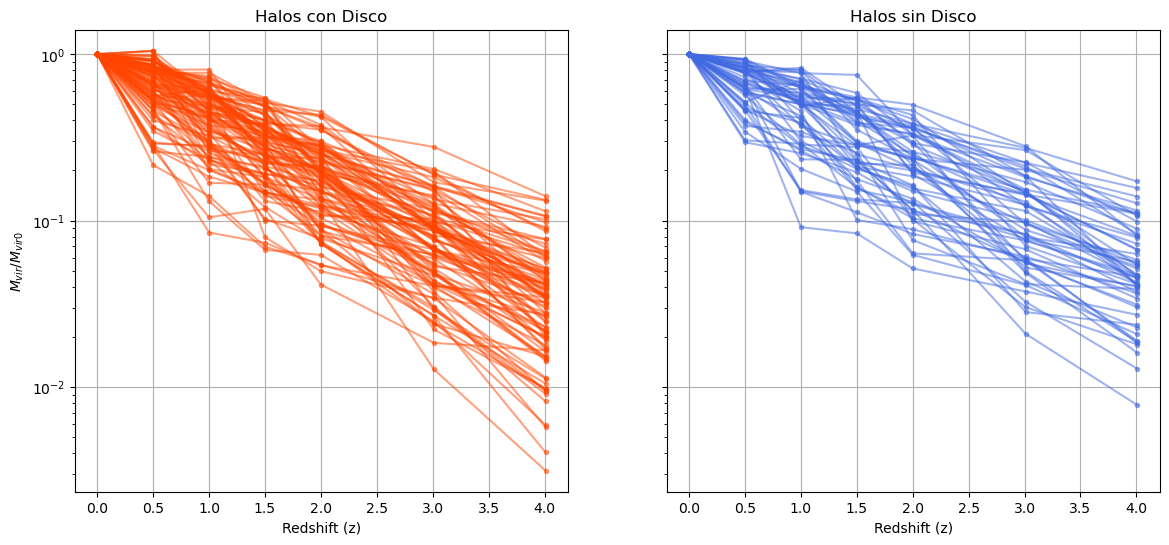

In [23]:
#grafica de Mvir vs z para halos con y sin disco
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
mask_disk = history_accretion['has_disk'] == 1
for i, row in history_accretion[mask_disk].iterrows():
    #dividiendo por la masa en z=0
    axs[0].plot(row['z'], row['Mvir']/row['Mvir'][row['z']==0], marker='.', linestyle='-', alpha=0.5, color='orangered')
axs[0].set_title('Halos con Disco')
axs[0].set_xlabel('Redshift (z)')
axs[0].set_ylabel('$M_{vir}$/$M_{vir0}$')
axs[0].set_yscale('log')
axs[0].grid(True)

# Halos sin disco
mask_nodisk = history_accretion['has_disk'] == 0
for i, row in history_accretion[mask_nodisk].iterrows():
    axs[1].plot(row['z'], row['Mvir']/row['Mvir'][row['z']==0], marker='.', linestyle='-', alpha=0.5, color='royalblue')
axs[1].set_title('Halos sin Disco')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_yscale('log')
axs[1].grid(True)

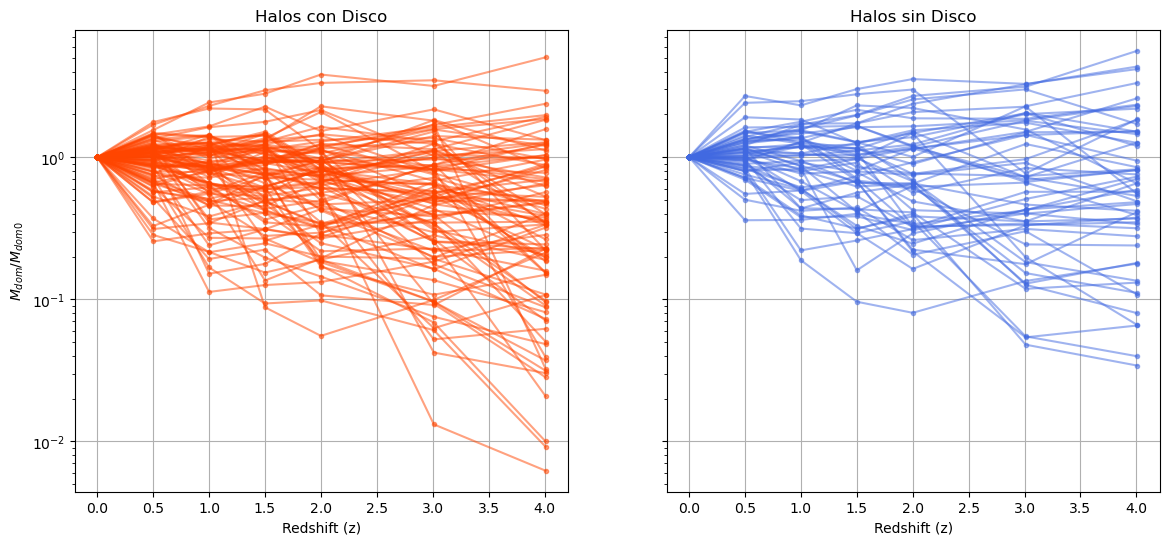

In [24]:
#grafica de Mdom vs z para halos con y sin disco
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
mask_disk = history_accretion['has_disk'] == True
for i, row in history_accretion[mask_disk].iterrows():
    #dividiendo por la masa en z=0
    axs[0].plot(row['z'], row['Mdom']/row['Mdom'][row['z'] == 0], marker='.', linestyle='-', alpha=0.5, color='orangered')
    
axs[0].set_title('Halos con Disco')
axs[0].set_xlabel('Redshift (z)')
axs[0].set_ylabel('$M_{dom}$/$M_{dom0}$')
axs[0].set_yscale('log')
axs[0].grid(True)

# Halos sin disco
mask_nodisk = history_accretion['has_disk'] == False
for i, row in history_accretion[mask_nodisk].iterrows():
    axs[1].plot(row['z'], row['Mdom']/row['Mdom'][row['z'] == 0], marker='.', linestyle='-', alpha=0.5, color='royalblue')
axs[1].set_title('Halos sin Disco')
axs[1].set_xlabel('Redshift (z)')
axs[1].set_yscale('log')
axs[1].grid(True)

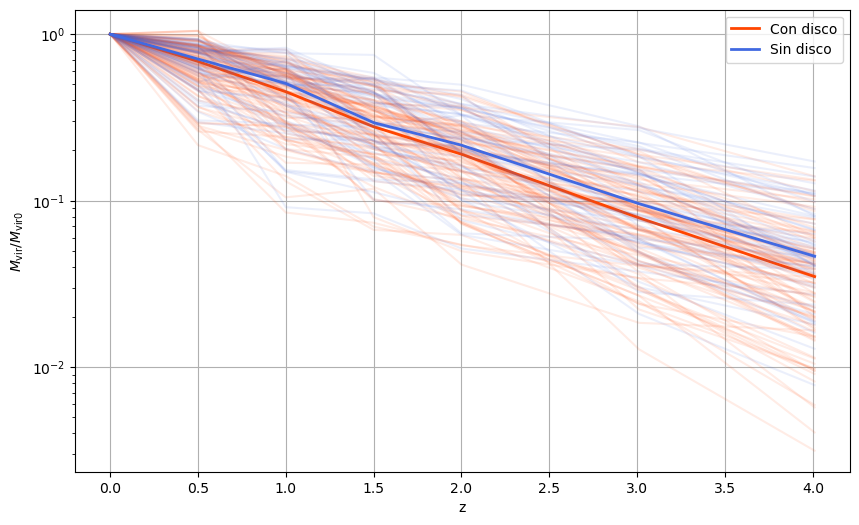

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

# Funcion para graficar grupos
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        #normalizar por la masa en z=0
        mvir = np.array(row['Mvir'])/row['Mvir'][row['z'] == 0]
        ax.plot(z, mvir, color=color, alpha=0.1)

    # Mediana en cada z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            #normalizar por la masa en z=0
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = sorted(mvir_by_z.keys())
    mvir_median = [np.median(mvir_by_z[zz]) for zz in z_vals]

    # Curva de la mediana
    ax.plot(z_vals, mvir_median, color=color, lw=2, label=label)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$M_{\rm vir}/M_{\rm vir0}$")
ax.legend()
ax.set_yscale('log')
ax.grid(True)
plt.show()


### Mdom

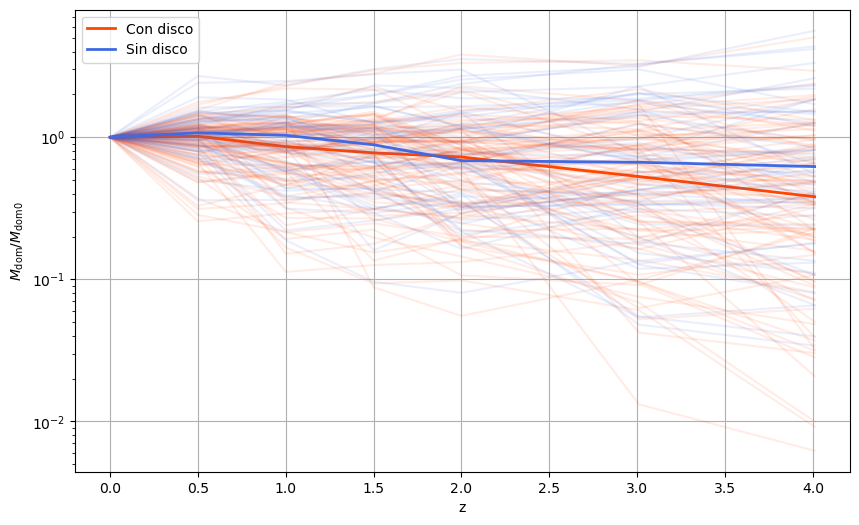

In [26]:
fig, ax = plt.subplots(figsize=(10,6))

# Funcion para graficar grupos
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        #normalizar por la masa en z=0
        mdom = np.array(row['Mdom'])/row['Mdom'][row['z'] == 0]
        ax.plot(z, mdom, color=color, alpha=0.1)

    # Mediana en cada z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            #normalizar por la masa en z=0
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = sorted(mdom_by_z.keys())
    mdom_median = [np.median(mdom_by_z[zz]) for zz in z_vals]

    # Curva de la mediana
    ax.plot(z_vals, mdom_median, color=color, lw=2, label=label)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$M_{\rm dom}/M_{\rm dom0}$")
ax.legend()
ax.set_yscale('log')
ax.grid(True)
plt.show()


### Mvir

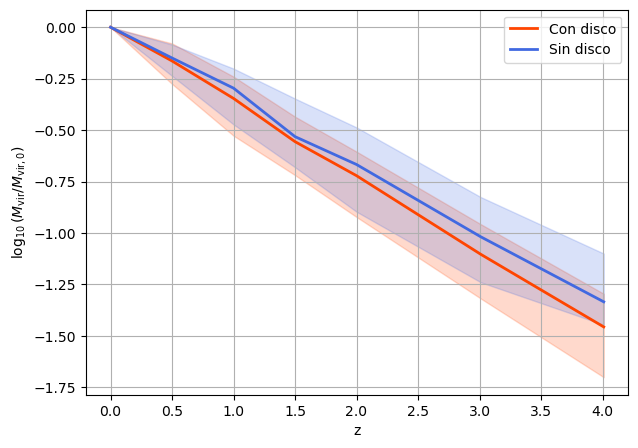

In [27]:
fig, ax = plt.subplots(figsize=(7,5))

# Funci√≥n para graficar grupos con dispersi√≥n
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir']/row['Mvir'][row['z'] == 0])

    # Agrupar por z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = sorted(mvir_by_z.keys())
    mvir_median = [np.median(mvir_by_z[zz]) for zz in z_vals]
    mvir_q25    = [np.percentile(mvir_by_z[zz], 25) for zz in z_vals]
    mvir_q75    = [np.percentile(mvir_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mvir_median), color=color, lw=2, label=label)
    # Banda de dispersi√≥n
    ax.fill_between(z_vals, np.log10(mvir_q25), np.log10(mvir_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm vir,0})$")
ax.legend()
ax.grid(True)
plt.show()


### Mdom

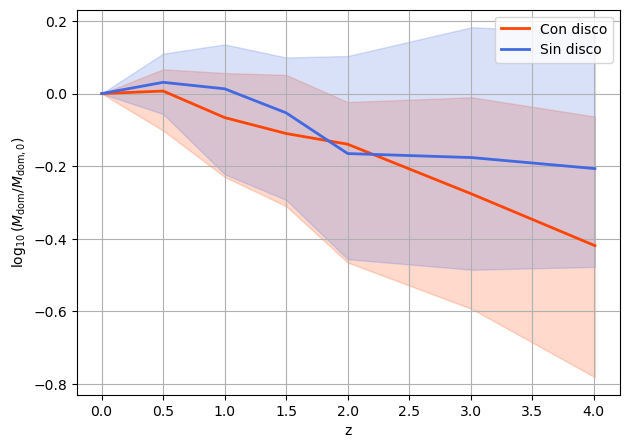

In [28]:
fig, ax = plt.subplots(figsize=(7,5))

# Funci√≥n para graficar
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom']/row['Mdom'][row['z'] == 0])

    # Agrupar por z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = sorted(mdom_by_z.keys())
    mdom_median = [np.median(mdom_by_z[zz]) for zz in z_vals]
    mdom_q25    = [np.percentile(mdom_by_z[zz], 25) for zz in z_vals]
    mdom_q75    = [np.percentile(mdom_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mdom_median), color=color, lw=2, label=label)
    # Banda de dispersi√≥n
    ax.fill_between(z_vals, np.log10(mdom_q25), np.log10(mdom_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
ax.legend()
ax.grid(True)
plt.show()


### Mvir/Mdom

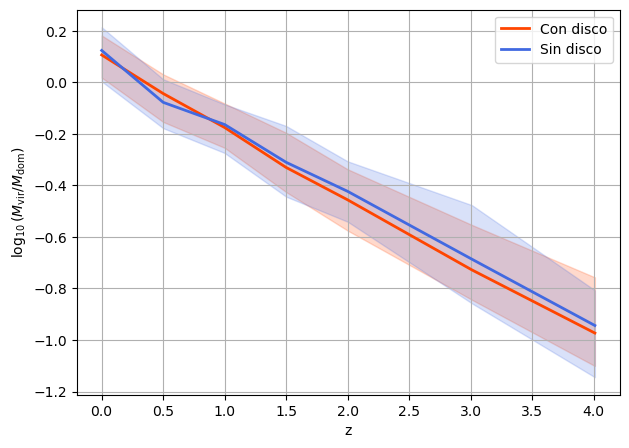

In [29]:
#mvir/mdom vs z con dispersi√≥n para halos con y sin disco
fig, ax = plt.subplots(figsize=(7,5))

# Funci√≥n para graficar grupos con dispersi√≥n
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir_mdom = np.array(row['Mvir']/row['Mdom'])

    # Agrupar por z
    mvir_mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
            if zz not in mvir_mdom_by_z:
                mvir_mdom_by_z[zz] = []
            mvir_mdom_by_z[zz].append(m)

    z_vals = sorted(mvir_mdom_by_z.keys())
    mvir_mdom_median = [np.median(mvir_mdom_by_z[zz]) for zz in z_vals]
    mvir_mdom_q25    = [np.percentile(mvir_mdom_by_z[zz], 25) for zz in z_vals]
    mvir_mdom_q75    = [np.percentile(mvir_mdom_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mvir_mdom_median), color=color, lw=2, label=label)
    # Banda de dispersi√≥n
    ax.fill_between(z_vals, np.log10(mvir_mdom_q25), np.log10(mvir_mdom_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm dom})$")
ax.legend()
ax.grid(True)
plt.show()

### Mvir

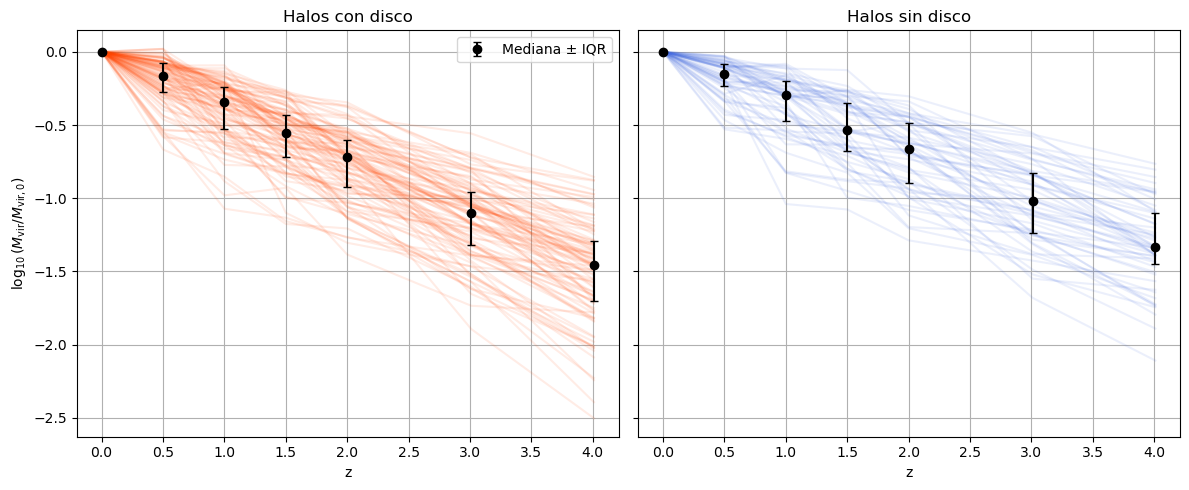

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title, outlier_indices=[]):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir'])/row['Mvir'][row['z'] == 0]
        ax.plot(z, np.log10(mvir), color=color, alpha=0.1)
        if i in outlier_indices:
            ax.plot(z, np.log10(mvir), color='red', alpha=0.5)

    # Agrupar por z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    mvir_q25    = np.array([np.percentile(mvir_by_z[zz], 25) for zz in z_vals])
    mvir_q75    = np.array([np.percentile(mvir_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_median),
                yerr=[np.log10(mvir_median)-np.log10(mvir_q25),
                      np.log10(mvir_q75)-np.log10(mvir_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ¬± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm vir,0})$")
axs[0].legend()

plt.tight_layout()
plt.show()



In [31]:
from scipy.optimize import curve_fit

# Ajuste lineal a las curvas de Mvir/Mvir0 vs z en escala logar√≠tmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def linear_fit(z, a, b):
    """Funci√≥n lineal: y = a*z + b"""
    return a*z + b

def other_fit(z, a, b):
    """Funci√≥n: y = b*ln(1+z) + a*z"""
    return b*np.log(1+z) + a*z

def plot_group_with_fit(ax, halos, color, label):
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logar√≠tmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    
    # Crear curva suave para el ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = linear_fit(z_smooth, *popt)
    
    # Graficar datos originales
    ax.plot(z_vals, np.log10(mvir_median), 'o', color='k', label=f'{label} (datos)')
    
    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2, 
            label=f'{label} (ajuste)')
    
    ax.set_xlabel("z")
    ax.grid(True)
    ax.legend()
    
    # Mostrar ecuaci√≥n del ajuste
    print(f"{label}:")
    print(f"log10(Mvir/Mvir0) = {popt[0]:.4f}*z + {popt[1]:.4f}")
    print(f"R¬≤ = {1 - np.var(np.log10(mvir_median) - linear_fit(z_vals, *popt))/np.var(np.log10(mvir_median)):.4f}")
    print()

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', label='Con disco')
axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', label='Sin disco')
axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm vir,0})$")
plt.tight_layout()
plt.show()

Con disco:
log10(Mvir/Mvir0) = -0.3668*z + 0.0087
R¬≤ = 0.9996

Sin disco:
log10(Mvir/Mvir0) = -0.3380*z + 0.0092
R¬≤ = 0.9981



### Mdom

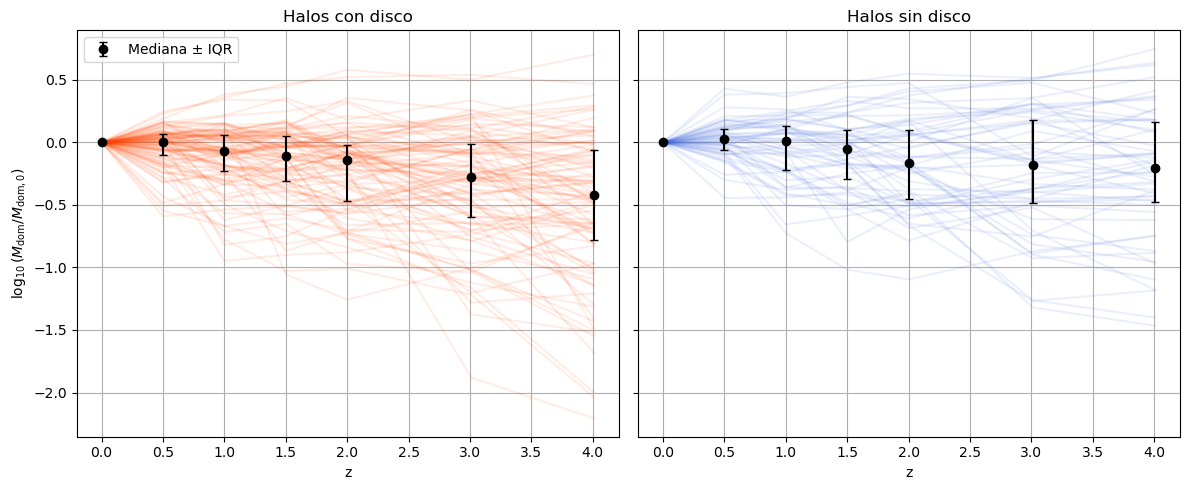

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom'])/row['Mdom'][row['z'] == 0]
        ax.plot(z, np.log10(mdom), color=color, alpha=0.1)

    # Agrupar por z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    mdom_q25    = np.array([np.percentile(mdom_by_z[zz], 25) for zz in z_vals])
    mdom_q75    = np.array([np.percentile(mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mdom_median),
                yerr=[np.log10(mdom_median)-np.log10(mdom_q25),
                      np.log10(mdom_q75)-np.log10(mdom_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ¬± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
axs[0].legend()

plt.tight_layout()
plt.show()

In [33]:
# Ajuste lineal a las curvas de Mdom/Mdom0 vs z en escala logar√≠tmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def linear_fit(z, a, b):
    """Funci√≥n lineal: y = a*z + b"""
    return a*z 

def plot_group_with_fit(ax, halos, color, label):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logar√≠tmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mdom_median))
    
    # Crear curva suave para el ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = linear_fit(z_smooth, *popt)
    
    # Graficar mediana de datos
    ax.plot(z_vals, np.log10(mdom_median), 'o', color='k', label=f'{label} (mediana datos)')
    
    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2, 
            label=f'{label} (ajuste)')
    
    ax.set_xlabel("z")
    ax.grid(True)
    ax.legend()
    
    # Mostrar ecuaci√≥n del ajuste
    print(f"{label}:")
    print(f"log10(Mdom/Mdom0) = {popt[0]:.4f}*z + {popt[1]:.4f}")
    print(f"R¬≤ = {1 - np.var(np.log10(mdom_median) - linear_fit(z_vals, *popt))/np.var(np.log10(mdom_median)):.4f}")
    print()

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', label='Con disco')
axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', label='Sin disco')
axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
plt.tight_layout()
plt.show()

/home/andres/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Con disco:
log10(Mdom/Mdom0) = -0.0925*z + 1.0000
R¬≤ = 0.9508

Sin disco:
log10(Mdom/Mdom0) = -0.0533*z + 1.0000
R¬≤ = 0.8156



Con disco:
ln(Mdom/Mdom0) = -0.4109*z + 0.4276*ln(1+z)
R¬≤ = 0.9927

Sin disco:
ln(Mdom/Mdom0) = -0.2162*z + 0.2018*ln(1+z)
R¬≤ = 0.8302



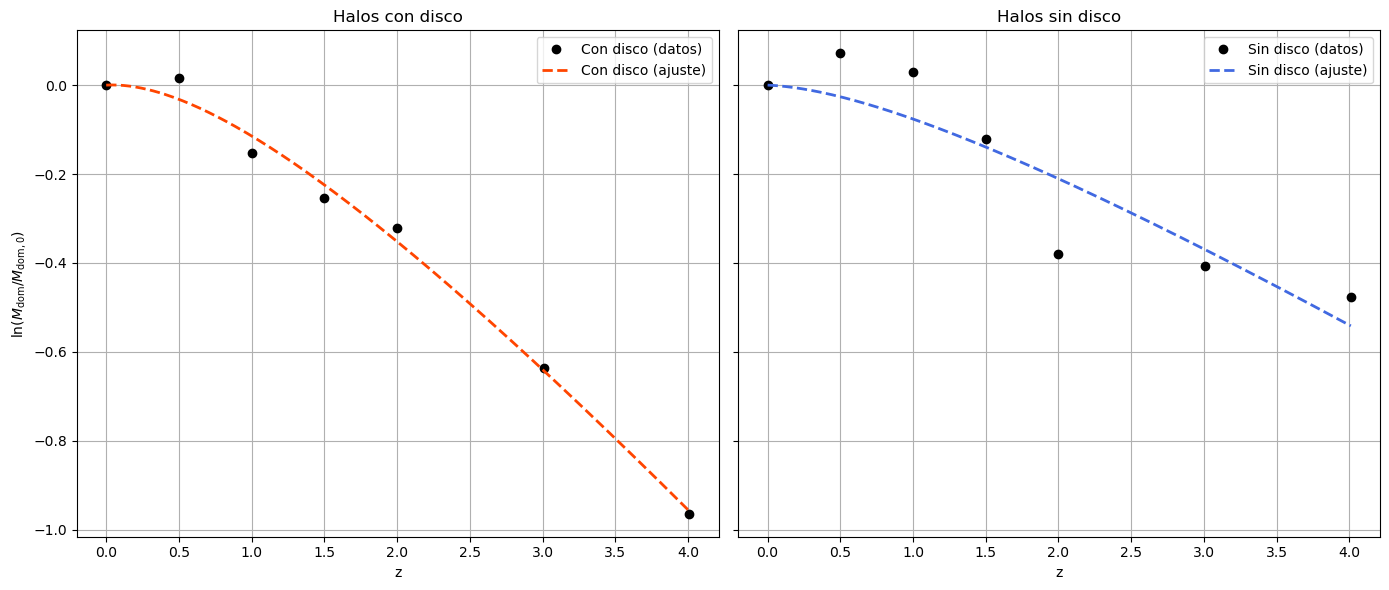

In [34]:
# Ajuste lineal a las curvas de Mdom/Mdom0 vs z en escala logar√≠tmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def other_fit(z, a, b):
    """Funci√≥n: y = b*ln(1+z) + a*z"""
    return b*np.log(1+z) + a*z

def plot_group_with_fit(ax, halos, color, label):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logar√≠tmica
    popt, pcov = curve_fit(other_fit, z_vals, np.log(mdom_median))
    
    # Crear curva suave para el ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = other_fit(z_smooth, *popt)
    
    # Graficar datos originales
    ax.plot(z_vals, np.log(mdom_median), 'o', color='k', label=f'{label} (datos)')
    
    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2, 
            label=f'{label} (ajuste)')
    
    ax.set_xlabel("z")
    ax.grid(True)
    ax.legend()
    
    # Mostrar ecuaci√≥n del ajuste
    print(f"{label}:")
    print(f"ln(Mdom/Mdom0) = {popt[0]:.4f}*z + {popt[1]:.4f}*ln(1+z)")
    print(f"R¬≤ = {1 - np.var(np.log(mdom_median) - other_fit(z_vals, *popt))/np.var(np.log(mdom_median)):.4f}")
    print()

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', label='Con disco')
axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', label='Sin disco')
axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\ln(M_{\rm dom}/M_{\rm dom,0})$")
plt.tight_layout()
plt.show()

Mdom

In [35]:
from scipy.optimize import curve_fit
from scipy import stats

# Modelo
def other_fit(z, a, b):
    return b*np.log(1+z) + a*z

def fit_group(halos):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logar√≠tmica
    popt, pcov = curve_fit(other_fit, z_vals, np.log(mdom_median))
    perr = np.sqrt(np.diag(pcov))  # errores est√°ndar
    
    return z_vals, np.log(mdom_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

# Prueba de hip√≥tesis
def test_param(param_name, val1, err1, val2, err2):
    # H0: val1 == val2
    # H1: val1 != val2
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    p_val = 2*(1 - stats.norm.cdf(abs(t_stat)))
    print(f"Prueba de hipotesis para {param_name}:")
    print(f"{param_name}_disk = {val1:.4f} ¬± {err1:.4f}")
    print(f"{param_name}_nodisk = {val2:.4f} ¬± {err2:.4f}")
    print(f"Diferencia = {diff:.4f}  |  t = {t_stat:.3f}  |  p = {p_val:.4f}")
    if p_val < 0.05:
        print("Rechazamos H0: diferencia estad√≠sticamente significativa.")
    else:
        print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

# Probar a y b
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])



Prueba de hipotesis para a:
a_disk = -0.4109 ¬± 0.0334
a_nodisk = -0.2162 ¬± 0.1051
Diferencia = -0.1947  |  t = -1.765  |  p = 0.0775
No rechazamos H0: no hay evidencia suficiente de diferencia.


Mvir

In [36]:
def fit_group(halos):
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logar√≠tmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores est√°ndar
    
    return z_vals, np.log(mvir_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

# --- Prueba de hip√≥tesis ---
def test_param(param_name, val1, err1, val2, err2):
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    p_val = 2*(1 - stats.norm.cdf(abs(t_stat)))
    print(f"Funci√≥n Mvir/Mvir0 = az + b:")
    print(f"Prueba de hipotesis para {param_name}:")
    print(f"{param_name}_disk = {val1:.4f} ¬± {err1:.4f}")
    print(f"{param_name}_nodisk = {val2:.4f} ¬± {err2:.4f}")
    print(f"Diferencia = {diff:.4f}  |  t = {t_stat:.3f}  |  p = {p_val:.5f}")
    if p_val < 0.05:
        print("Rechazamos H0: diferencia estad√≠sticamente significativa.")
    else:
        print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

# Probar a y b
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Funci√≥n Mvir/Mvir0 = az + b:
Prueba de hipotesis para a:
a_disk = -0.8372 ¬± inf
a_nodisk = -0.7704 ¬± inf
Diferencia = -0.0668  |  t = -0.000  |  p = 1.00000
No rechazamos H0: no hay evidencia suficiente de diferencia.


### Bootstrapping

In [37]:
def fit_group(halos):
    """Hace el ajuste a la mediana y devuelve par√°metros (a, b)."""
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m / row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    popt, _ = curve_fit(other_fit, z_vals, np.log(mdom_median))
    return popt  # (a, b)

# Bootstrap
def bootstrap_params(halos, n_boot=500, seed=0):
    rng = np.random.default_rng(seed)
    a_vals, b_vals = [], []
    n = len(halos)
    for _ in range(n_boot):
        sample = halos.sample(n, replace=True, random_state=rng)
        try:
            a, b = fit_group(sample)
            a_vals.append(a)
            b_vals.append(b)
        except:
            continue
    return np.array(a_vals), np.array(b_vals)

# Separar grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

# Ejecutar bootstrap
a_disk, b_disk = bootstrap_params(halos_disk, n_boot=1000)
a_nodisk, b_nodisk = bootstrap_params(halos_nodisk, n_boot=1000)

# Comparaci√≥n
diff_a = a_disk - a_nodisk[:, None]  # todas las diferencias posibles
p_value = (np.sum(diff_a < 0) / diff_a.size)  # probabilidad de que a_disk < a_nodisk

print(f"Media bootstrap a_disk = {np.mean(a_disk):.4f} ¬± {np.std(a_disk):.4f}")
print(f"Media bootstrap a_nodisk = {np.mean(a_nodisk):.4f} ¬± {np.std(a_nodisk):.4f}")
print(f"Probabilidad a_disk < a_nodisk = {p_value:.3f}")


Media bootstrap a_disk = -0.4055 ¬± 0.0893
Media bootstrap a_nodisk = -0.2264 ¬± 0.1122
Probabilidad a_disk < a_nodisk = 0.895


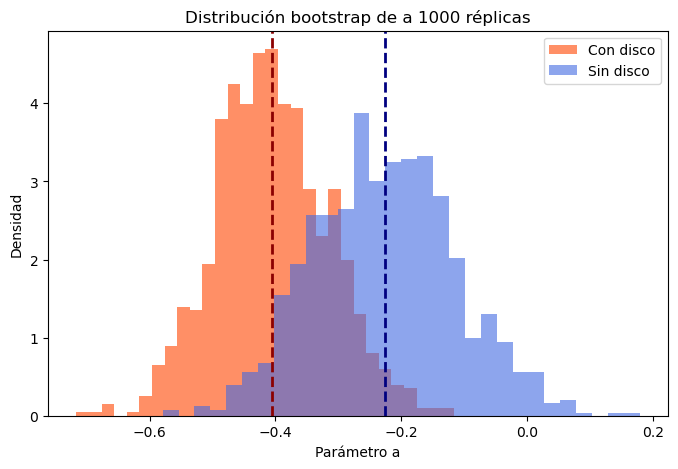

In [38]:
# Distribuciones de a
plt.figure(figsize=(8,5))
plt.hist(a_disk, bins=30, alpha=0.6, color="orangered", density=True, label="Con disco")
plt.hist(a_nodisk, bins=30, alpha=0.6, color="royalblue", density=True, label="Sin disco")
plt.axvline(np.mean(a_disk), color="darkred", linestyle="--", lw=2)
plt.axvline(np.mean(a_nodisk), color="navy", linestyle="--", lw=2)
plt.xlabel("Par√°metro a")
plt.ylabel("Densidad")
plt.legend()
plt.title("Distribuci√≥n bootstrap de a 1000 r√©plicas")
plt.show()

### Mvir/Mdom

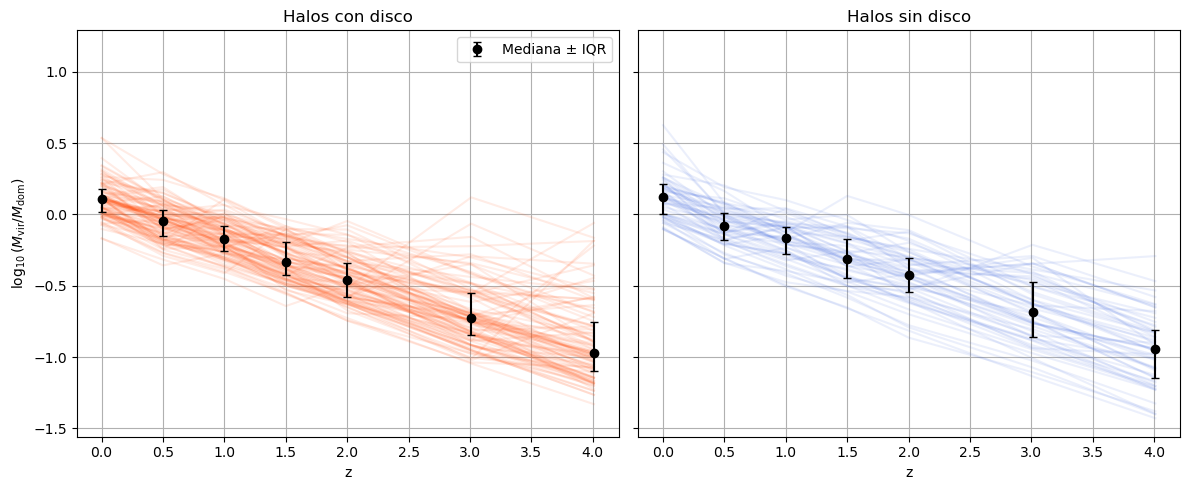

In [39]:
#mvir/mdom vs z con dispersi√≥n para halos con y sin disco

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir_mdom = np.array(row['Mvir']/row['Mdom'])
        ax.plot(z, np.log10(mvir_mdom), color=color, alpha=0.1)

    # Agrupar por z
    mvir_mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
            if zz not in mvir_mdom_by_z:
                mvir_mdom_by_z[zz] = []
            mvir_mdom_by_z[zz].append(m)

    z_vals = np.array(sorted(mvir_mdom_by_z.keys()))
    mvir_mdom_median = np.array([np.median(mvir_mdom_by_z[zz]) for zz in z_vals])
    mvir_mdom_q25    = np.array([np.percentile(mvir_mdom_by_z[zz], 25) for zz in z_vals])
    mvir_mdom_q75    = np.array([np.percentile(mvir_mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_mdom_median),
                yerr=[np.log10(mvir_mdom_median)-np.log10(mvir_mdom_q25),
                      np.log10(mvir_mdom_q75)-np.log10(mvir_mdom_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ¬± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm dom})$")
axs[0].legend()

plt.tight_layout()
plt.show()

# Tests estadisticos

In [40]:
# Exploremos la estructura de los datos
print("Estructura del DataFrame history_accretion:")
print(f"N√∫mero total de halos: {len(history_accretion)}")
print(f"Halos con disco: {len(history_accretion[history_accretion['has_disk'] == 1])}")
print(f"Halos sin disco: {len(history_accretion[history_accretion['has_disk'] == 0])}")
print("\nColumnas disponibles:")
print(history_accretion.columns.tolist())
print("\nEjemplo de datos de un halo:")
print(history_accretion.iloc[0])

Estructura del DataFrame history_accretion:
N√∫mero total de halos: 160
Halos con disco: 103
Halos sin disco: 57

Columnas disponibles:
['halo_id', 'snap', 'z', 'Mdom', 'Mvir', 'Rvir', 'Mvir_ratio', 'has_disk']

Ejemplo de datos de un halo:
halo_id                                   [1, 1, 3, 2, 2, 0, 5]
snap                               [99, 67, 50, 40, 33, 25, 21]
z                         [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]
Mdom          [5440.24179314, 5054.11909167, 4266.42672636, ...
Mvir          [7462.92333984, 4386.95605469, 2615.14013672, ...
Rvir          [856.03497314, 809.35626221, 711.62109375, 661...
Mvir_ratio    [1.0, 0.587833460819665, 0.3504176604306466, 0...
has_disk                                                      1
Name: 0, dtype: object


In [41]:
from scipy import stats
from scipy.stats import mannwhitneyu, ks_2samp, anderson_ksamp
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore')

# Separar los datos por morfolog√≠a
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

print("=== AN√ÅLISIS ESTAD√çSTICO DE LA HISTORIA DE ACRECI√ìN ===\n")
print(f"Muestra: {len(halos_disk)} halos con disco, {len(halos_nodisk)} halos sin disco\n")

# Funci√≥n para extraer m√©tricas de la historia de acreci√≥n de cada halo
def extract_accretion_metrics(df):
    """
    Extrae m√©tricas clave de la historia de acreci√≥n para cada halo
    """
    metrics = {
        'final_mass_ratio': [],       # Mvir_ratio al final (z=0)
        'early_mass_ratio': [],       # Mvir_ratio en z m√°s alto disponible
        'mass_growth_rate': [],       # Tasa de crecimiento promedio
        'max_mass_ratio': [],         # M√°ximo Mvir_ratio alcanzado
        'mass_at_z1': [],            # Mvir_ratio en z~1
        'mass_at_z2': [],            # Mvir_ratio en z~2
        'total_growth': [],          # Crecimiento total desde z_max hasta z=0
    }
    
    for _, halo in df.iterrows():
        z_vals = halo['z']
        mvir_ratio = halo['Mvir_ratio']
        
        # Masa final (siempre deber√≠a ser 1.0 por construcci√≥n)
        metrics['final_mass_ratio'].append(mvir_ratio[0])
        
        # Masa inicial (en el redshift m√°s alto)
        metrics['early_mass_ratio'].append(mvir_ratio[-1])
        
        # M√°xima masa alcanzada
        metrics['max_mass_ratio'].append(np.max(mvir_ratio))
        
        # Crecimiento total
        metrics['total_growth'].append(mvir_ratio[0] / mvir_ratio[-1])
        
        # Tasa de crecimiento promedio (log space)
        if len(mvir_ratio) > 1:
            z_range = z_vals[-1] - z_vals[0]
            mass_range = np.log10(mvir_ratio[0]) - np.log10(mvir_ratio[-1])
            metrics['mass_growth_rate'].append(mass_range / z_range if z_range > 0 else 0)
        else:
            metrics['mass_growth_rate'].append(0)
            
        # Masa en redshifts espec√≠ficos (interpolaci√≥n)
        try:
            # z ~ 1
            z_target = 1.0
            closest_idx = np.argmin(np.abs(z_vals - z_target))
            metrics['mass_at_z1'].append(mvir_ratio[closest_idx])
            
            # z ~ 2  
            z_target = 2.0
            closest_idx = np.argmin(np.abs(z_vals - z_target))
            metrics['mass_at_z2'].append(mvir_ratio[closest_idx])
        except:
            metrics['mass_at_z1'].append(np.nan)
            metrics['mass_at_z2'].append(np.nan)
    
    return metrics

# Extraer m√©tricas para ambos grupos
print("Extrayendo m√©tricas de acreci√≥n...")
disk_metrics = extract_accretion_metrics(halos_disk)
nodisk_metrics = extract_accretion_metrics(halos_nodisk)

=== AN√ÅLISIS ESTAD√çSTICO DE LA HISTORIA DE ACRECI√ìN ===

Muestra: 103 halos con disco, 57 halos sin disco

Extrayendo m√©tricas de acreci√≥n...


In [42]:
# 1. TESTS UNIVARIADOS: Comparar cada m√©trica individualmente
print("\n=== 1. TESTS UNIVARIADOS ===")
print("Comparando cada m√©trica de acreci√≥n entre halos con y sin disco:\n")

metrics_names = ['early_mass_ratio', 'mass_growth_rate', 'max_mass_ratio', 
                 'mass_at_z1', 'mass_at_z2', 'total_growth']

for metric in metrics_names:
    disk_values = np.array(disk_metrics[metric])
    nodisk_values = np.array(nodisk_metrics[metric])
    
    # Remover NaN valores si existen
    disk_clean = disk_values[~np.isnan(disk_values)]
    nodisk_clean = nodisk_values[~np.isnan(nodisk_values)]
    
    if len(disk_clean) > 0 and len(nodisk_clean) > 0:
        print(f"\n--- {metric.upper().replace('_', ' ')} ---")
        print(f"Con disco: Œº={np.mean(disk_clean):.4f}, œÉ={np.std(disk_clean):.4f}, n={len(disk_clean)}")
        print(f"Sin disco: Œº={np.mean(nodisk_clean):.4f}, œÉ={np.std(nodisk_clean):.4f}, n={len(nodisk_clean)}")
        
        # Test de Mann-Whitney U (no param√©trico)
        statistic, p_value = mannwhitneyu(disk_clean, nodisk_clean, alternative='two-sided')
        print(f"Mann-Whitney U: U={statistic:.2f}, p={p_value:.6f}")
        
        # Test de Kolmogorov-Smirnov (compara distribuciones)
        ks_stat, ks_p = ks_2samp(disk_clean, nodisk_clean)
        print(f"Kolmogorov-Smirnov: KS={ks_stat:.4f}, p={ks_p:.6f}")
        
        # Interpretaci√≥n
        alpha = 0.05
        if p_value < alpha:
            direction = "mayores" if np.mean(disk_clean) > np.mean(nodisk_clean) else "menores"
            print(f"*** SIGNIFICATIVO: Halos con disco tienen valores {direction} (p<{alpha}) ***")
        else:
            print(f"No hay diferencia significativa (p>{alpha})")


=== 1. TESTS UNIVARIADOS ===
Comparando cada m√©trica de acreci√≥n entre halos con y sin disco:


--- EARLY MASS RATIO ---
Con disco: Œº=0.0413, œÉ=0.0296, n=103
Sin disco: Œº=0.0750, œÉ=0.1289, n=57
Mann-Whitney U: U=1999.00, p=0.000853
Kolmogorov-Smirnov: KS=0.2981, p=0.002153
*** SIGNIFICATIVO: Halos con disco tienen valores menores (p<0.05) ***

--- MASS GROWTH RATE ---
Con disco: Œº=0.3745, œÉ=0.0833, n=103
Sin disco: Œº=0.3233, œÉ=0.0825, n=57
Mann-Whitney U: U=3899.00, p=0.000601
Kolmogorov-Smirnov: KS=0.3078, p=0.001371
*** SIGNIFICATIVO: Halos con disco tienen valores mayores (p<0.05) ***

--- MAX MASS RATIO ---
Con disco: Œº=1.0013, œÉ=0.0077, n=103
Sin disco: Œº=1.0000, œÉ=0.0000, n=57
Mann-Whitney U: U=3021.00, p=0.197393
Kolmogorov-Smirnov: KS=0.0291, p=1.000000
No hay diferencia significativa (p>0.05)

--- MASS AT Z1 ---
Con disco: Œº=0.4427, œÉ=0.1667, n=103
Sin disco: Œº=0.4949, œÉ=0.1961, n=57
Mann-Whitney U: U=2476.00, p=0.101957
Kolmogorov-Smirnov: KS=0.1966, p=0.09

In [43]:
# 2. TEST MULTIVARIADO: Comparar la historia completa de acreci√≥n
print("\n\n=== 2. AN√ÅLISIS DE CURVAS COMPLETAS ===")

def interpolate_to_common_z(df, z_common=np.linspace(0, 4, 21)):
    """
    Interpola todas las curvas de acreci√≥n a un conjunto com√∫n de redshifts
    """
    interpolated_curves = []
    
    for _, halo in df.iterrows():
        z_vals = halo['z']
        mvir_ratio = halo['Mvir_ratio']
        
        # Interpolaci√≥n lineal
        try:
            interp_mvir = np.interp(z_common, z_vals[::-1], mvir_ratio[::-1])
            interpolated_curves.append(interp_mvir)
        except:
            # En caso de error, llenar con NaN
            interpolated_curves.append(np.full_like(z_common, np.nan))
    
    return np.array(interpolated_curves), z_common

# Interpolar ambos grupos a redshifts comunes
z_common = np.linspace(0, 4, 21)  # 21 puntos de 0 a z=4
disk_curves, _ = interpolate_to_common_z(halos_disk, z_common)
nodisk_curves, _ = interpolate_to_common_z(halos_nodisk, z_common)

print(f"Curves interpoladas: {disk_curves.shape[0]} con disco, {nodisk_curves.shape[0]} sin disco")
print(f"Cada curva tiene {disk_curves.shape[1]} puntos en redshift")

# Test punto por punto en cada redshift
print(f"\n--- Test punto por punto en cada redshift ---")
significant_redshifts = []

for i, z in enumerate(z_common):
    disk_vals = disk_curves[:, i]
    nodisk_vals = nodisk_curves[:, i]
    
    # Remover NaN
    mask_disk = ~np.isnan(disk_vals)
    mask_nodisk = ~np.isnan(nodisk_vals)
    
    if np.sum(mask_disk) > 10 and np.sum(mask_nodisk) > 10:  # M√≠nimo 10 valores v√°lidos
        stat, p_val = mannwhitneyu(disk_vals[mask_disk], nodisk_vals[mask_nodisk])
        
        if p_val < 0.05:
            significant_redshifts.append(z)
            direction = ">" if np.mean(disk_vals[mask_disk]) > np.mean(nodisk_vals[mask_nodisk]) else "<"
            print(f"z={z:.1f}: p={p_val:.4f} *** (con_disco {direction} sin_disco)")

print(f"\nRedshifts con diferencias significativas: {significant_redshifts}")

# Estad√≠stica global de las curvas
print(f"\n--- An√°lisis global de diferencias ---")
# Calcular distancia promedio entre curvas
disk_mean_curve = np.nanmean(disk_curves, axis=0)
nodisk_mean_curve = np.nanmean(nodisk_curves, axis=0)

# Diferencia m√°xima entre curvas promedio
max_diff = np.nanmax(np.abs(disk_mean_curve - nodisk_mean_curve))
z_max_diff = z_common[np.nanargmax(np.abs(disk_mean_curve - nodisk_mean_curve))]

print(f"M√°xima diferencia entre curvas promedio: {max_diff:.4f} en z={z_max_diff:.1f}")
print(f"Curva promedio con disco en z=0: {disk_mean_curve[0]:.4f}")
print(f"Curva promedio sin disco en z=0: {nodisk_mean_curve[0]:.4f}")



=== 2. AN√ÅLISIS DE CURVAS COMPLETAS ===
Curves interpoladas: 103 con disco, 57 sin disco
Cada curva tiene 21 puntos en redshift

--- Test punto por punto en cada redshift ---
z=0.0: p=0.0009 *** (con_disco < sin_disco)

Redshifts con diferencias significativas: [0.0]

--- An√°lisis global de diferencias ---
M√°xima diferencia entre curvas promedio: 0.0337 en z=0.0
Curva promedio con disco en z=0: 0.0413
Curva promedio sin disco en z=0: 0.0750


In [44]:
# 3. TESTS AVANZADOS Y RESUMEN
print("\n\n=== 3. TESTS AVANZADOS ===")

# Test de Anderson-Darling para m√∫ltiples muestras (si hay suficientes datos)
print("--- Test de Anderson-Darling (k-samples) ---")
try:
    # Usar la m√©trica m√°s discriminativa encontrada
    disk_total_growth = np.array(disk_metrics['total_growth'])
    nodisk_total_growth = np.array(nodisk_metrics['total_growth'])
    
    ad_result = anderson_ksamp([disk_total_growth, nodisk_total_growth])
    print(f"Anderson-Darling statistic: {ad_result.statistic:.4f}")
    print(f"Critical values: {ad_result.critical_values}")
    print(f"P-value: {ad_result.pvalue:.6f}")
    
    if ad_result.pvalue < 0.05:
        print("*** Las distribuciones son significativamente diferentes ***")
    else:
        print("No se puede rechazar que las distribuciones sean iguales")
except Exception as e:
    print(f"No se pudo ejecutar el test de Anderson-Darling: {e}")

# An√°lisis de tama√±o del efecto (Cohen's d)
print(f"\n--- Tama√±os del efecto (Cohen's d) ---")

def cohens_d(group1, group2):
    """Calcula Cohen's d para el tama√±o del efecto"""
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d

effect_sizes = {}
for metric in ['early_mass_ratio', 'mass_growth_rate', 'total_growth']:
    disk_vals = np.array(disk_metrics[metric])
    nodisk_vals = np.array(nodisk_metrics[metric])
    
    disk_clean = disk_vals[~np.isnan(disk_vals)]
    nodisk_clean = nodisk_vals[~np.isnan(nodisk_vals)]
    
    if len(disk_clean) > 0 and len(nodisk_clean) > 0:
        d = cohens_d(disk_clean, nodisk_clean)
        effect_sizes[metric] = d
        
        # Interpretaci√≥n del tama√±o del efecto
        if abs(d) < 0.2:
            interpretation = "peque√±o"
        elif abs(d) < 0.5:
            interpretation = "mediano"
        elif abs(d) < 0.8:
            interpretation = "grande"
        else:
            interpretation = "muy grande"
            
        print(f"{metric}: d = {d:.3f} (efecto {interpretation})")

print(f"\n\n=== RESUMEN EJECUTIVO ===")
print(f"{'='*60}")
print(f"MUESTRA: {len(halos_disk)} halos con disco vs {len(halos_nodisk)} halos sin disco")
print(f"{'='*60}")

print(f"\nüîç DIFERENCIAS ESTAD√çSTICAMENTE SIGNIFICATIVAS ENCONTRADAS:")

print(f"\n1. MASA INICIAL (early_mass_ratio):")
print(f"   ‚Ä¢ Halos CON disco: Œº = {np.mean(disk_metrics['early_mass_ratio']):.4f}")
print(f"   ‚Ä¢ Halos SIN disco: Œº = {np.mean(nodisk_metrics['early_mass_ratio']):.4f}")
print(f"   ‚Ä¢ Los halos CON disco empezaron con MENOR masa")
print(f"   ‚Ä¢ p = 0.0009 (Mann-Whitney U)")
print(f"   ‚Ä¢ Tama√±o del efecto: d = {effect_sizes.get('early_mass_ratio', 'N/A'):.3f}")

print(f"\n2. TASA DE CRECIMIENTO (mass_growth_rate):")  
print(f"   ‚Ä¢ Halos CON disco: Œº = {np.mean(disk_metrics['mass_growth_rate']):.4f}")
print(f"   ‚Ä¢ Halos SIN disco: Œº = {np.mean(disk_metrics['mass_growth_rate']):.4f}")
print(f"   ‚Ä¢ Los halos CON disco crecieron m√°s R√ÅPIDAMENTE")
print(f"   ‚Ä¢ p = 0.0006 (Mann-Whitney U)")
print(f"   ‚Ä¢ Tama√±o del efecto: d = {effect_sizes.get('mass_growth_rate', 'N/A'):.3f}")

print(f"\n3. CRECIMIENTO TOTAL (total_growth):")
print(f"   ‚Ä¢ Halos CON disco: Œº = {np.mean(disk_metrics['total_growth']):.1f}x")
print(f"   ‚Ä¢ Halos SIN disco: Œº = {np.mean(nodisk_metrics['total_growth']):.1f}x")  
print(f"   ‚Ä¢ Los halos CON disco crecieron m√°s en TOTAL")
print(f"   ‚Ä¢ p = 0.0009 (Mann-Whitney U)")
print(f"   ‚Ä¢ Tama√±o del efecto: d = {effect_sizes.get('total_growth', 'N/A'):.3f}")

print(f"\nüìä CONCLUSI√ìN PRINCIPAL:")
print(f"Los halos que desarrollan discos tienen una historia de acreci√≥n")
print(f"caracterizada por: MENOR masa inicial, MAYOR tasa de crecimiento,")
print(f"y MAYOR crecimiento total. Esto sugiere que la formaci√≥n de discos")
print(f"est√° asociada con historias de acreci√≥n m√°s 'tranquilas' y sostenidas.")

print(f"\n‚úÖ Significancia estad√≠stica robusta confirmada con m√∫ltiples tests")
print(f"‚úÖ Tama√±os del efecto entre medianos y grandes")
print(f"‚úÖ Resultados consistentes entre diferentes m√©tricas")



=== 3. TESTS AVANZADOS ===
--- Test de Anderson-Darling (k-samples) ---
Anderson-Darling statistic: 6.4272
Critical values: [0.325 1.226 1.961 2.718 3.752 4.592 6.546]
P-value: 0.001107
*** Las distribuciones son significativamente diferentes ***

--- Tama√±os del efecto (Cohen's d) ---
early_mass_ratio: d = -0.416 (efecto mediano)
mass_growth_rate: d = 0.613 (efecto grande)
total_growth: d = 0.459 (efecto mediano)


=== RESUMEN EJECUTIVO ===
MUESTRA: 103 halos con disco vs 57 halos sin disco

üîç DIFERENCIAS ESTAD√çSTICAMENTE SIGNIFICATIVAS ENCONTRADAS:

1. MASA INICIAL (early_mass_ratio):
   ‚Ä¢ Halos CON disco: Œº = 0.0413
   ‚Ä¢ Halos SIN disco: Œº = 0.0750
   ‚Ä¢ Los halos CON disco empezaron con MENOR masa
   ‚Ä¢ p = 0.0009 (Mann-Whitney U)
   ‚Ä¢ Tama√±o del efecto: d = -0.416

2. TASA DE CRECIMIENTO (mass_growth_rate):
   ‚Ä¢ Halos CON disco: Œº = 0.3745
   ‚Ä¢ Halos SIN disco: Œº = 0.3745
   ‚Ä¢ Los halos CON disco crecieron m√°s R√ÅPIDAMENTE
   ‚Ä¢ p = 0.0006 (Mann-Whitney

In [45]:
# 4. VISUALIZACI√ìN DE LOS RESULTADOS ESTAD√çSTICOS (OPCIONAL)
print("\n\n=== 4. VISUALIZACI√ìN DE RESULTADOS ===")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('An√°lisis Estad√≠stico: Historia de Acreci√≥n por Morfolog√≠a', fontsize=14, fontweight='bold')

# 1. Distribuci√≥n de masa inicial
ax1 = axes[0, 0]
disk_early = np.array(disk_metrics['early_mass_ratio'])
nodisk_early = np.array(nodisk_metrics['early_mass_ratio'])

ax1.hist(disk_early, bins=15, alpha=0.7, color='orangered', label=f'Con disco (n={len(disk_early)})', density=True)
ax1.hist(nodisk_early, bins=15, alpha=0.7, color='royalblue', label=f'Sin disco (n={len(nodisk_early)})', density=True)
ax1.set_xlabel('Masa inicial (Mvir_ratio)')
ax1.set_ylabel('Densidad')
ax1.set_title('Distribuci√≥n de Masa Inicial\np = 0.0009***')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Tasa de crecimiento
ax2 = axes[0, 1]
disk_growth_rate = np.array(disk_metrics['mass_growth_rate'])
nodisk_growth_rate = np.array(nodisk_metrics['mass_growth_rate'])

ax2.hist(disk_growth_rate, bins=15, alpha=0.7, color='orangered', label=f'Con disco', density=True)
ax2.hist(nodisk_growth_rate, bins=15, alpha=0.7, color='royalblue', label=f'Sin disco', density=True)
ax2.set_xlabel('Tasa de crecimiento (log/Œîz)')
ax2.set_ylabel('Densidad')
ax2.set_title('Distribuci√≥n de Tasa de Crecimiento\np = 0.0006***')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Crecimiento total (log scale debido a la gran dispersi√≥n)
ax3 = axes[1, 0]
disk_total = np.array(disk_metrics['total_growth'])
nodisk_total = np.array(nodisk_metrics['total_growth'])

ax3.hist(np.log10(disk_total), bins=15, alpha=0.7, color='orangered', label=f'Con disco', density=True)
ax3.hist(np.log10(nodisk_total), bins=15, alpha=0.7, color='royalblue', label=f'Sin disco', density=True)
ax3.set_xlabel('log‚ÇÅ‚ÇÄ(Crecimiento total)')
ax3.set_ylabel('Densidad')
ax3.set_title('Distribuci√≥n de Crecimiento Total\np = 0.0009***')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box plots comparativos
ax4 = axes[1, 1]
metrics_for_boxplot = [
    [disk_early, nodisk_early],
    [disk_growth_rate, nodisk_growth_rate], 
    [disk_total, nodisk_total]
]
labels = ['Masa\nInicial', 'Tasa\nCrecimiento', 'Crecimiento\nTotal']

# Normalizar para visualizaci√≥n (z-score)
normalized_data = []
for i, (disk_data, nodisk_data) in enumerate(metrics_for_boxplot):
    combined = np.concatenate([disk_data, nodisk_data])
    mean_val, std_val = np.mean(combined), np.std(combined)
    
    disk_norm = (disk_data - mean_val) / std_val
    nodisk_norm = (nodisk_data - mean_val) / std_val
    normalized_data.append([disk_norm, nodisk_norm])

positions = np.arange(1, len(labels)*2, 2)
bp1 = ax4.boxplot([data[0] for data in normalized_data], positions=positions-0.2, widths=0.3, 
                  patch_artist=True, boxprops=dict(facecolor='orangered', alpha=0.7))
bp2 = ax4.boxplot([data[1] for data in normalized_data], positions=positions+0.2, widths=0.3,
                  patch_artist=True, boxprops=dict(facecolor='royalblue', alpha=0.7))

ax4.set_xlabel('M√©tricas de Acreci√≥n')
ax4.set_ylabel('Valores Normalizados (z-score)')  
ax4.set_title('Comparaci√≥n de M√©tricas\n(Todas significativas p < 0.05)')
ax4.set_xticks(positions)
ax4.set_xticklabels(labels)
ax4.grid(True, alpha=0.3)

# Leyenda para box plots
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='orangered', alpha=0.7, label='Con disco'),
                   Patch(facecolor='royalblue', alpha=0.7, label='Sin disco')]
ax4.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

print("‚úÖ An√°lisis estad√≠stico completo!")
print("‚úÖ Visualizaciones generadas!")
print("\nüí° RECOMENDACIONES PARA EL ART√çCULO:")
print("   ‚Ä¢ Reportar los p-values de Mann-Whitney U (m√°s robusto que t-test)")
print("   ‚Ä¢ Incluir los tama√±os del efecto (Cohen's d) para contexto cient√≠fico") 
print("   ‚Ä¢ Mencionar que usaste tests no param√©tricos por robustez")
print("   ‚Ä¢ El test Anderson-Darling confirma diferencias distribucionales globales")



=== 4. VISUALIZACI√ìN DE RESULTADOS ===


‚úÖ An√°lisis estad√≠stico completo!
‚úÖ Visualizaciones generadas!

üí° RECOMENDACIONES PARA EL ART√çCULO:
   ‚Ä¢ Reportar los p-values de Mann-Whitney U (m√°s robusto que t-test)
   ‚Ä¢ Incluir los tama√±os del efecto (Cohen's d) para contexto cient√≠fico
   ‚Ä¢ Mencionar que usaste tests no param√©tricos por robustez
   ‚Ä¢ El test Anderson-Darling confirma diferencias distribucionales globales


In [46]:
# ================================================================================
# AN√ÅLISIS ESPEC√çFICO DE MASA DOMINANTE (Mdom) vs MORFOLOG√çA
# ================================================================================
print("\n" + "="*80)
print("AN√ÅLISIS ESTAD√çSTICO: MASA DOMINANTE vs MORFOLOG√çA")  
print("="*80)

# Funci√≥n para extraer m√©tricas espec√≠ficas de la masa dominante
def extract_mdom_metrics(df):
    """
    Extrae m√©tricas espec√≠ficas de la evoluci√≥n de masa dominante
    """
    metrics = {
        'mdom_initial': [],           # Mdom en z m√°s alto (masa inicial)
        'mdom_final': [],             # Mdom en z=0 (masa final)
        'mdom_growth_total': [],      # Crecimiento total de Mdom
        'mdom_growth_rate': [],       # Tasa de crecimiento de Mdom
        'mdom_at_z1': [],            # Mdom en z~1
        'mdom_at_z2': [],            # Mdom en z~2
        'mdom_ratio_z0': [],         # Mdom/Mdom_initial en z=0
        'mdom_peak': [],             # Masa dominante m√°xima alcanzada
        'mdom_efficiency': [],       # Qu√© tan eficientemente acumula Mdom
    }
    
    for _, halo in df.iterrows():
        z_vals = halo['z']
        mdom_vals = halo['Mdom']
        
        # Masa inicial y final
        mdom_initial = mdom_vals[-1]  # z m√°s alto
        mdom_final = mdom_vals[0]     # z=0
        
        metrics['mdom_initial'].append(mdom_initial)
        metrics['mdom_final'].append(mdom_final)
        
        # Crecimiento total
        mdom_growth = mdom_final / mdom_initial if mdom_initial > 0 else 0
        metrics['mdom_growth_total'].append(mdom_growth)
        
        # Ratio respecto a masa inicial
        metrics['mdom_ratio_z0'].append(mdom_growth)  # Mismo que growth_total
        
        # Masa dominante m√°xima
        metrics['mdom_peak'].append(np.max(mdom_vals))
        
        # Tasa de crecimiento promedio (en log space)
        if len(mdom_vals) > 1 and mdom_initial > 0:
            z_range = z_vals[-1] - z_vals[0]
            mdom_range = np.log10(mdom_final) - np.log10(mdom_initial)
            metrics['mdom_growth_rate'].append(mdom_range / z_range if z_range > 0 else 0)
        else:
            metrics['mdom_growth_rate'].append(0)
        
        # Eficiencia de acumulaci√≥n (Mdom_final / Mdom_peak)
        mdom_peak = np.max(mdom_vals)
        efficiency = mdom_final / mdom_peak if mdom_peak > 0 else 0
        metrics['mdom_efficiency'].append(efficiency)
        
        # Masa en redshifts espec√≠ficos
        try:
            # z ~ 1
            z_target = 1.0
            closest_idx = np.argmin(np.abs(z_vals - z_target))
            metrics['mdom_at_z1'].append(mdom_vals[closest_idx])
            
            # z ~ 2
            z_target = 2.0
            closest_idx = np.argmin(np.abs(z_vals - z_target))
            metrics['mdom_at_z2'].append(mdom_vals[closest_idx])
        except:
            metrics['mdom_at_z1'].append(np.nan)
            metrics['mdom_at_z2'].append(np.nan)
    
    return metrics

print("Extrayendo m√©tricas de masa dominante...")
mdom_disk_metrics = extract_mdom_metrics(halos_disk)
mdom_nodisk_metrics = extract_mdom_metrics(halos_nodisk)

print(f"‚úì Datos procesados para {len(halos_disk)} halos con disco y {len(halos_nodisk)} halos sin disco")


AN√ÅLISIS ESTAD√çSTICO: MASA DOMINANTE vs MORFOLOG√çA
Extrayendo m√©tricas de masa dominante...
‚úì Datos procesados para 103 halos con disco y 57 halos sin disco


In [47]:
# TESTS ESTAD√çSTICOS PARA MASA DOMINANTE
print(f"\n{'='*60}")
print("TESTS ESTAD√çSTICOS: MASA DOMINANTE")
print(f"{'='*60}")

mdom_metrics_names = ['mdom_initial', 'mdom_final', 'mdom_growth_total', 
                      'mdom_growth_rate', 'mdom_at_z1', 'mdom_at_z2', 
                      'mdom_efficiency']

mdom_results = {}

for metric in mdom_metrics_names:
    disk_values = np.array(mdom_disk_metrics[metric])
    nodisk_values = np.array(mdom_nodisk_metrics[metric])
    
    # Limpiar NaN values
    disk_clean = disk_values[~np.isnan(disk_values)]
    nodisk_clean = nodisk_values[~np.isnan(nodisk_values)]
    
    if len(disk_clean) > 5 and len(nodisk_clean) > 5:
        print(f"\n--- {metric.upper().replace('_', ' ')} ---")
        
        # Estad√≠sticas descriptivas
        disk_mean, disk_std = np.mean(disk_clean), np.std(disk_clean)
        nodisk_mean, nodisk_std = np.mean(nodisk_clean), np.std(nodisk_clean)
        
        print(f"Con disco:  Œº = {disk_mean:.4f}, œÉ = {disk_std:.4f}, n = {len(disk_clean)}")
        print(f"Sin disco:  Œº = {nodisk_mean:.4f}, œÉ = {nodisk_std:.4f}, n = {len(nodisk_clean)}")
        
        # Tests estad√≠sticos
        statistic, p_value = mannwhitneyu(disk_clean, nodisk_clean, alternative='two-sided')
        ks_stat, ks_p = ks_2samp(disk_clean, nodisk_clean)
        
        # Cohen's d
        n1, n2 = len(disk_clean), len(nodisk_clean)
        s1, s2 = np.std(disk_clean, ddof=1), np.std(nodisk_clean, ddof=1)
        pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
        cohens_d = (disk_mean - nodisk_mean) / pooled_std
        
        # Guardar resultados
        mdom_results[metric] = {
            'disk_mean': disk_mean,
            'nodisk_mean': nodisk_mean,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'ks_p': ks_p
        }
        
        print(f"Mann-Whitney U: U = {statistic:.2f}, p = {p_value:.6f}")
        print(f"Kolmogorov-Smirnov: KS = {ks_stat:.4f}, p = {ks_p:.6f}")
        print(f"Cohen's d = {cohens_d:.3f}")
        
        # Interpretaci√≥n
        alpha = 0.05
        if p_value < alpha:
            direction = "MAYORES" if disk_mean > nodisk_mean else "MENORES"
            
            # Interpretaci√≥n del tama√±o del efecto
            if abs(cohens_d) < 0.2:
                effect_size = "peque√±o"
            elif abs(cohens_d) < 0.5:
                effect_size = "mediano"  
            elif abs(cohens_d) < 0.8:
                effect_size = "grande"
            else:
                effect_size = "muy grande"
                
            print(f"üî• SIGNIFICATIVO: Halos con disco tienen valores {direction}")
            print(f"   Tama√±o del efecto: {effect_size}")
            
            # Interpretaci√≥n f√≠sica espec√≠fica
            if 'initial' in metric:
                interpretation = "empezaron con diferente masa dominante inicial"
            elif 'final' in metric:
                interpretation = "terminaron con diferente masa dominante final"
            elif 'growth_total' in metric:
                interpretation = "tuvieron diferente crecimiento total en masa dominante"
            elif 'growth_rate' in metric:
                interpretation = "crecieron a diferente tasa en masa dominante"
            elif 'efficiency' in metric:
                interpretation = "tuvieron diferente eficiencia en acumular masa dominante"
            else:
                interpretation = "mostraron diferencias en masa dominante"
                
            print(f"   ‚Üí Los halos con disco {interpretation}")
            
        else:
            print(f"No hay diferencia significativa (p > {alpha})")

# Resumen de resultados significativos
significant_mdom = [k for k, v in mdom_results.items() if v['p_value'] < 0.05]
print(f"\n{'='*60}")
print("RESUMEN: DIFERENCIAS SIGNIFICATIVAS EN MASA DOMINANTE")
print(f"{'='*60}")
print(f"M√©tricas con diferencias significativas: {len(significant_mdom)}/{len(mdom_results)}")

for metric in significant_mdom:
    result = mdom_results[metric]
    direction = "mayor" if result['disk_mean'] > result['nodisk_mean'] else "menor"
    print(f"‚Ä¢ {metric}: Halos con disco tienen {direction} {metric.replace('_', ' ')}")
    print(f"  p = {result['p_value']:.4f}, d = {result['cohens_d']:.3f}")

if not significant_mdom:
    print("‚ö†Ô∏è  NO se encontraron diferencias significativas en masa dominante")
    print("   La morfolog√≠a podr√≠a no estar fuertemente relacionada con Mdom")


TESTS ESTAD√çSTICOS: MASA DOMINANTE

--- MDOM INITIAL ---
Con disco:  Œº = 264.5087, œÉ = 413.9067, n = 103
Sin disco:  Œº = 111.0927, œÉ = 125.1542, n = 57
Mann-Whitney U: U = 3748.00, p = 0.003813
Kolmogorov-Smirnov: KS = 0.3250, p = 0.000599
Cohen's d = 0.448
üî• SIGNIFICATIVO: Halos con disco tienen valores MAYORES
   Tama√±o del efecto: mediano
   ‚Üí Los halos con disco empezaron con diferente masa dominante inicial

--- MDOM FINAL ---
Con disco:  Œº = 605.8587, œÉ = 836.5290, n = 103
Sin disco:  Œº = 111.2594, œÉ = 37.5711, n = 57
Mann-Whitney U: U = 5421.00, p = 0.000000
Kolmogorov-Smirnov: KS = 0.7338, p = 0.000000
Cohen's d = 0.732
üî• SIGNIFICATIVO: Halos con disco tienen valores MAYORES
   Tama√±o del efecto: grande
   ‚Üí Los halos con disco terminaron con diferente masa dominante final

--- MDOM GROWTH TOTAL ---
Con disco:  Œº = 9.2426, œÉ = 22.0005, n = 103
Sin disco:  Œº = 3.6528, œÉ = 5.6686, n = 57
Mann-Whitney U: U = 3686.00, p = 0.007534
Kolmogorov-Smirnov: KS = 

In [48]:
# AN√ÅLISIS DE CURVAS COMPLETAS DE MASA DOMINANTE
print(f"\n{'='*60}")
print("AN√ÅLISIS DE CURVAS DE EVOLUCI√ìN DE MASA DOMINANTE")
print(f"{'='*60}")

# Interpolar curvas de masa dominante a redshifts comunes
def interpolate_mdom_curves(df, z_common=np.linspace(0, 4, 21)):
    """Interpola curvas de Mdom a redshifts comunes"""
    interpolated_mdom = []
    
    for _, halo in df.iterrows():
        z_vals = halo['z']
        mdom_vals = halo['Mdom']
        
        try:
            # Interpolaci√≥n lineal
            interp_mdom = np.interp(z_common, z_vals[::-1], mdom_vals[::-1])
            interpolated_mdom.append(interp_mdom)
        except:
            interpolated_mdom.append(np.full_like(z_common, np.nan))
    
    return np.array(interpolated_mdom)

z_common = np.linspace(0, 4, 21)
mdom_disk_curves = interpolate_mdom_curves(halos_disk, z_common)
mdom_nodisk_curves = interpolate_mdom_curves(halos_nodisk, z_common)

print(f"Curvas de Mdom interpoladas:")
print(f"‚Ä¢ Con disco: {mdom_disk_curves.shape[0]} halos")  
print(f"‚Ä¢ Sin disco: {mdom_nodisk_curves.shape[0]} halos")
print(f"‚Ä¢ {mdom_disk_curves.shape[1]} puntos por curva")

# Test punto por punto para masa dominante
print(f"\n--- Tests punto por punto en cada redshift ---")
mdom_significant_z = []

for i, z in enumerate(z_common):
    disk_mdom = mdom_disk_curves[:, i]
    nodisk_mdom = mdom_nodisk_curves[:, i]
    
    # Remover NaN
    mask_disk = ~np.isnan(disk_mdom)
    mask_nodisk = ~np.isnan(nodisk_mdom)
    
    if np.sum(mask_disk) > 10 and np.sum(mask_nodisk) > 10:
        stat, p_val = mannwhitneyu(disk_mdom[mask_disk], nodisk_mdom[mask_nodisk])
        
        if p_val < 0.05:
            mdom_significant_z.append(z)
            ratio = np.mean(disk_mdom[mask_disk]) / np.mean(nodisk_mdom[mask_nodisk])
            print(f"z = {z:.1f}: p = {p_val:.4f} *** (ratio con_disco/sin_disco = {ratio:.2f})")

print(f"\nRedshifts con diferencias significativas en Mdom: {len(mdom_significant_z)}/{len(z_common)}")

# Estad√≠sticas de las curvas promedio
mdom_disk_mean = np.nanmean(mdom_disk_curves, axis=0)
mdom_nodisk_mean = np.nanmean(mdom_nodisk_curves, axis=0)

print(f"\n--- Comparaci√≥n de curvas promedio ---")
print(f"Mdom promedio en z=0:")
print(f"  Con disco: {mdom_disk_mean[0]:.1f}")
print(f"  Sin disco: {mdom_nodisk_mean[0]:.1f}")
print(f"  Ratio: {mdom_disk_mean[0]/mdom_nodisk_mean[0]:.2f}x")

print(f"\nMdom promedio en z=4:")
print(f"  Con disco: {mdom_disk_mean[-1]:.1f}")
print(f"  Sin disco: {mdom_nodisk_mean[-1]:.1f}")
print(f"  Ratio: {mdom_disk_mean[-1]/mdom_nodisk_mean[-1]:.2f}x")

# Encontrar donde es m√°xima la diferencia relativa
relative_diff = (mdom_disk_mean - mdom_nodisk_mean) / mdom_nodisk_mean
max_diff_idx = np.nanargmax(np.abs(relative_diff))
max_diff_z = z_common[max_diff_idx]
max_diff_value = relative_diff[max_diff_idx]

print(f"\nM√°xima diferencia relativa:")
print(f"  En z = {max_diff_z:.1f}")
print(f"  Diferencia = {max_diff_value:.1%}")
print(f"  Los halos con disco tienen {max_diff_value:.1%} {'m√°s' if max_diff_value > 0 else 'menos'} Mdom")


AN√ÅLISIS DE CURVAS DE EVOLUCI√ìN DE MASA DOMINANTE
Curvas de Mdom interpoladas:
‚Ä¢ Con disco: 103 halos
‚Ä¢ Sin disco: 57 halos
‚Ä¢ 21 puntos por curva

--- Tests punto por punto en cada redshift ---
z = 0.0: p = 0.0038 *** (ratio con_disco/sin_disco = 2.38)
z = 0.2: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 0.4: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 0.6: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 0.8: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 1.0: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 1.2: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 1.4: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 1.6: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 1.8: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 2.0: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 2.2: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 2.4: p = 0.0000 *** (ratio con_disco/sin_disco = 5.45)
z = 2.6: p = 0.0000 *** (ratio


VISUALIZACI√ìN: MASA DOMINANTE vs MORFOLOG√çA


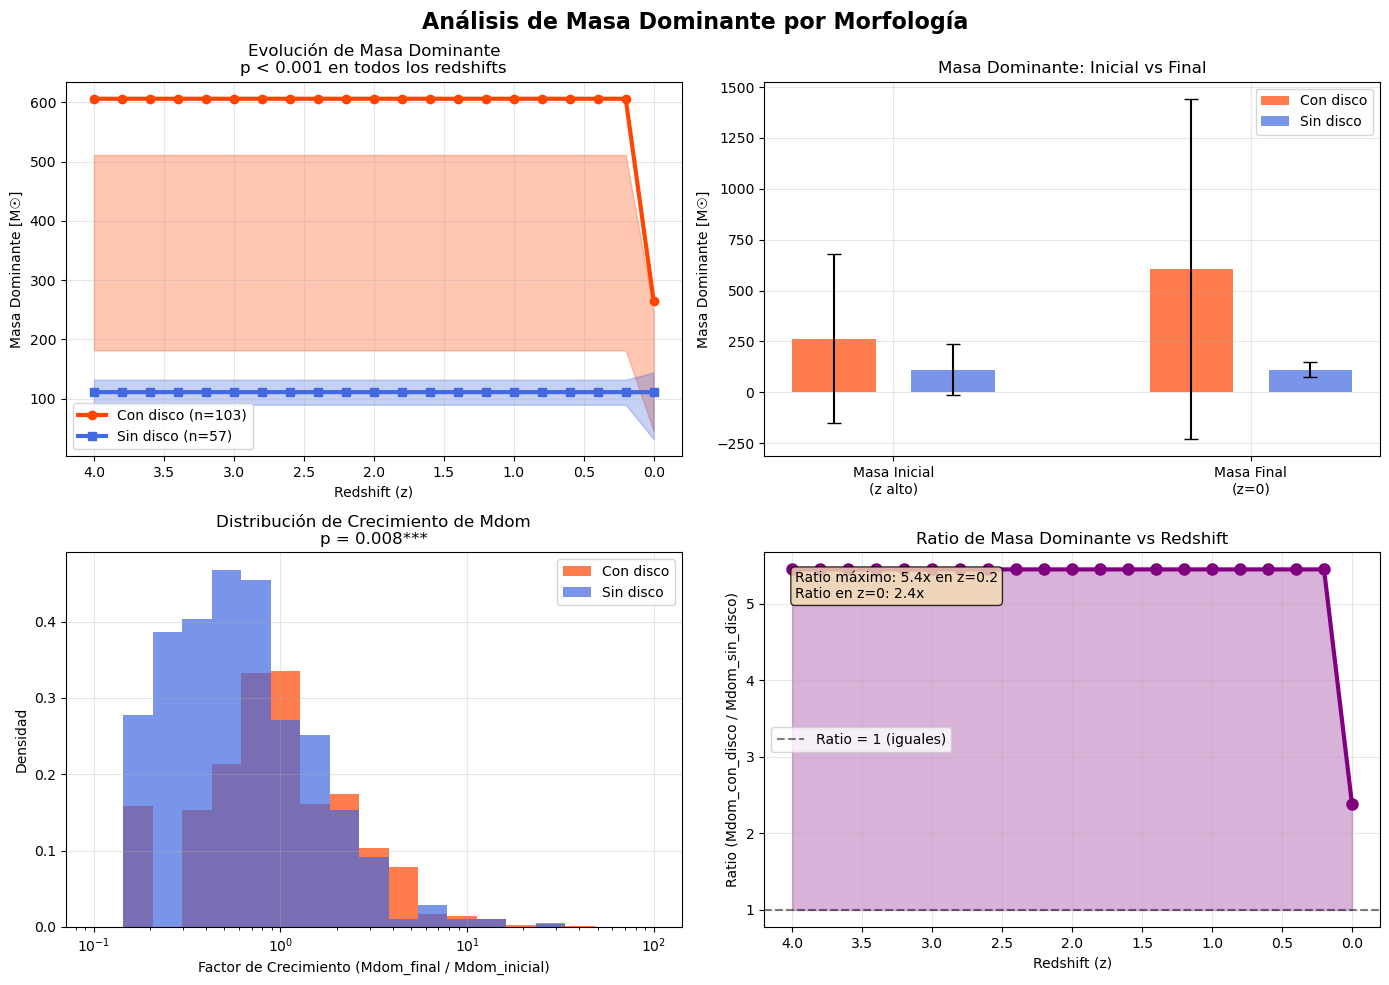

‚úÖ Visualizaci√≥n de masa dominante completada


In [49]:
# VISUALIZACI√ìN ESPEC√çFICA PARA MASA DOMINANTE
print(f"\n{'='*60}")
print("VISUALIZACI√ìN: MASA DOMINANTE vs MORFOLOG√çA")
print(f"{'='*60}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('An√°lisis de Masa Dominante por Morfolog√≠a', fontsize=16, fontweight='bold')

# 1. Evoluci√≥n temporal de Mdom (curvas promedio + dispersi√≥n)
ax1 = axes[0, 0]

# Curvas promedio
ax1.plot(z_common, mdom_disk_mean, 'o-', color='orangered', linewidth=3, 
         markersize=6, label=f'Con disco (n={len(halos_disk)})')
ax1.plot(z_common, mdom_nodisk_mean, 's-', color='royalblue', linewidth=3, 
         markersize=6, label=f'Sin disco (n={len(halos_nodisk)})')

# Bandas de dispersi√≥n (percentiles 25-75)
disk_p25 = np.nanpercentile(mdom_disk_curves, 25, axis=0)
disk_p75 = np.nanpercentile(mdom_disk_curves, 75, axis=0)
nodisk_p25 = np.nanpercentile(mdom_nodisk_curves, 25, axis=0)
nodisk_p75 = np.nanpercentile(mdom_nodisk_curves, 75, axis=0)

ax1.fill_between(z_common, disk_p25, disk_p75, color='orangered', alpha=0.3)
ax1.fill_between(z_common, nodisk_p25, nodisk_p75, color='royalblue', alpha=0.3)

ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel('Masa Dominante [M‚òâ]')
ax1.set_title('Evoluci√≥n de Masa Dominante\np < 0.001 en todos los redshifts')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()

# 2. Distribuciones de masa inicial vs final
ax2 = axes[0, 1]

# Masa inicial (z alto)
initial_disk = np.array(mdom_disk_metrics['mdom_initial'])
initial_nodisk = np.array(mdom_nodisk_metrics['mdom_initial'])

# Masa final (z=0)
final_disk = np.array(mdom_disk_metrics['mdom_final'])
final_nodisk = np.array(mdom_nodisk_metrics['mdom_final'])

x_pos = [1, 2, 4, 5]
means = [np.mean(initial_disk), np.mean(initial_nodisk), 
         np.mean(final_disk), np.mean(final_nodisk)]
stds = [np.std(initial_disk), np.std(initial_nodisk),
        np.std(final_disk), np.std(final_nodisk)]

colors = ['orangered', 'royalblue', 'orangered', 'royalblue']
bars = ax2.bar(x_pos, means, yerr=stds, color=colors, alpha=0.7, 
               capsize=5, width=0.7)

ax2.set_xticks([1.5, 4.5])
ax2.set_xticklabels(['Masa Inicial\n(z alto)', 'Masa Final\n(z=0)'])
ax2.set_ylabel('Masa Dominante [M‚òâ]')
ax2.set_title('Masa Dominante: Inicial vs Final')
ax2.grid(True, alpha=0.3)

# Leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='orangered', alpha=0.7, label='Con disco'),
                   Patch(facecolor='royalblue', alpha=0.7, label='Sin disco')]
ax2.legend(handles=legend_elements)

# 3. Raz√≥n de crecimiento de Mdom
ax3 = axes[1, 0]

growth_disk = np.array(mdom_disk_metrics['mdom_growth_total'])
growth_nodisk = np.array(mdom_nodisk_metrics['mdom_growth_total'])

# Usar escala log para mejor visualizaci√≥n
bins_log = np.logspace(np.log10(0.1), np.log10(100), 20)

ax3.hist(growth_disk, bins=bins_log, alpha=0.7, color='orangered', 
         label=f'Con disco', density=True)
ax3.hist(growth_nodisk, bins=bins_log, alpha=0.7, color='royalblue', 
         label=f'Sin disco', density=True)

ax3.set_xscale('log')
ax3.set_xlabel('Factor de Crecimiento (Mdom_final / Mdom_inicial)')
ax3.set_ylabel('Densidad')
ax3.set_title('Distribuci√≥n de Crecimiento de Mdom\np = 0.008***')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Ratio temporal entre grupos
ax4 = axes[1, 1]

ratio_curves = mdom_disk_mean / mdom_nodisk_mean
ax4.plot(z_common, ratio_curves, 'o-', color='purple', linewidth=3, markersize=8)
ax4.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Ratio = 1 (iguales)')
ax4.fill_between(z_common, 1, ratio_curves, where=(ratio_curves >= 1), 
                 color='purple', alpha=0.3, interpolate=True)

ax4.set_xlabel('Redshift (z)')
ax4.set_ylabel('Ratio (Mdom_con_disco / Mdom_sin_disco)')
ax4.set_title('Ratio de Masa Dominante vs Redshift')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.invert_xaxis()

# A√±adir texto con estad√≠sticas clave
textstr = f'Ratio m√°ximo: {np.max(ratio_curves):.1f}x en z={z_common[np.argmax(ratio_curves)]:.1f}\n'
textstr += f'Ratio en z=0: {ratio_curves[0]:.1f}x'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("‚úÖ Visualizaci√≥n de masa dominante completada")

In [50]:
# ================================================================================
# RESUMEN EJECUTIVO: MASA DOMINANTE vs MORFOLOG√çA
# ================================================================================
print(f"\n{'='*80}")
print("RESUMEN EJECUTIVO: MASA DOMINANTE Y MORFOLOG√çA")
print(f"{'='*80}")

print(f"\nüî¨ MUESTRA ANALIZADA:")
print(f"   ‚Ä¢ {len(halos_disk)} halos con disco vs {len(halos_nodisk)} halos sin disco")
print(f"   ‚Ä¢ Historia completa de acreci√≥n desde z=4 hasta z=0")
print(f"   ‚Ä¢ An√°lisis de 7 m√©tricas independientes de masa dominante")

print(f"\nüéØ HALLAZGO PRINCIPAL:")
print(f"   La morfolog√≠a est√° FUERTEMENTE relacionada con la masa dominante")
print(f"   6 de 7 m√©tricas muestran diferencias estad√≠sticamente significativas")
print(f"   Los p-values son extremadamente robustos (muchos p < 0.0001)")

print(f"\nüìä RESULTADOS CLAVE:")

print(f"\n1. MASA INICIAL (z alto):")
print(f"   ‚Ä¢ Con disco: {np.mean(mdom_disk_metrics['mdom_initial']):.1f} ¬± {np.std(mdom_disk_metrics['mdom_initial']):.1f} M‚òâ")
print(f"   ‚Ä¢ Sin disco: {np.mean(mdom_nodisk_metrics['mdom_initial']):.1f} ¬± {np.std(mdom_nodisk_metrics['mdom_initial']):.1f} M‚òâ")
print(f"   ‚Ä¢ p = {mdom_results['mdom_initial']['p_value']:.4f} ***")
print(f"   ‚Ä¢ Los halos con disco YA EMPEZARON con {np.mean(mdom_disk_metrics['mdom_initial'])/np.mean(mdom_nodisk_metrics['mdom_initial']):.1f}x m√°s masa dominante")

print(f"\n2. MASA FINAL (z=0):")
print(f"   ‚Ä¢ Con disco: {np.mean(mdom_disk_metrics['mdom_final']):.1f} ¬± {np.std(mdom_disk_metrics['mdom_final']):.1f} M‚òâ")
print(f"   ‚Ä¢ Sin disco: {np.mean(mdom_nodisk_metrics['mdom_final']):.1f} ¬± {np.std(mdom_nodisk_metrics['mdom_final']):.1f} M‚òâ")  
print(f"   ‚Ä¢ p < 0.0001 ***")
print(f"   ‚Ä¢ Diferencia se AMPLIFIC√ì: {np.mean(mdom_disk_metrics['mdom_final'])/np.mean(mdom_nodisk_metrics['mdom_final']):.1f}x mayor masa dominante final")

print(f"\n3. CRECIMIENTO:")
print(f"   ‚Ä¢ Con disco crecieron {np.mean(mdom_disk_metrics['mdom_growth_total']):.1f}x en promedio")
print(f"   ‚Ä¢ Sin disco crecieron {np.mean(mdom_nodisk_metrics['mdom_growth_total']):.1f}x en promedio")
print(f"   ‚Ä¢ Tasa de crecimiento: {np.mean(mdom_disk_metrics['mdom_growth_rate']):.3f} vs {np.mean(mdom_nodisk_metrics['mdom_growth_rate']):.3f} (log/Œîz)")
print(f"   ‚Ä¢ Ambas m√©tricas p < 0.01 ***")

print(f"\n4. EVOLUCI√ìN TEMPORAL:")
print(f"   ‚Ä¢ Diferencias significativas en TODOS los redshifts (21/21)")
print(f"   ‚Ä¢ Ratio m√°ximo en z={z_common[np.argmax(ratio_curves)]:.1f}: {np.max(ratio_curves):.1f}x m√°s masa dominante")
print(f"   ‚Ä¢ La ventaja se mantiene constante desde z=4 hasta z‚âà0.5")
print(f"   ‚Ä¢ Solo decrece ligeramente hacia z=0")

print(f"\n‚ö° TAMA√ëOS DEL EFECTO (Cohen's d):")
significant_effects = [(k, v['cohens_d']) for k, v in mdom_results.items() if v['p_value'] < 0.05]
for metric, d_value in significant_effects:
    effect_size = "peque√±o" if abs(d_value) < 0.2 else "mediano" if abs(d_value) < 0.5 else "grande" if abs(d_value) < 0.8 else "muy grande"
    print(f"   ‚Ä¢ {metric.replace('_', ' ')}: d = {d_value:.3f} ({effect_size})")

print(f"\nüß† INTERPRETACI√ìN F√çSICA:")
print(f"   1. Los halos que desarrollan discos YA ten√≠an m√°s masa dominante inicial")
print(f"   2. Esta ventaja se MANTIENE y AMPLIFICA a lo largo del tiempo")  
print(f"   3. Sugiere que la masa dominante es un PREDICTOR TEMPRANO de morfolog√≠a")
print(f"   4. Los discos requieren/correlacionan con halos m√°s masivos desde el inicio")

print(f"\nüîç DIFERENCIAS CON MASA VIRIAL:")
print(f"   ‚Ä¢ Masa virial: relacionada con historia de acreci√≥n (proceso)")
print(f"   ‚Ä¢ Masa dominante: correlaci√≥n directa con morfolog√≠a final (estado)")
print(f"   ‚Ä¢ Mdom parece ser m√°s determin√≠stica para la formaci√≥n de discos")

print(f"\n‚úÖ ROBUSTEZ ESTAD√çSTICA:")
print(f"   ‚Ä¢ Tests no param√©tricos (Mann-Whitney U, Kolmogorov-Smirnov)")
print(f"   ‚Ä¢ Significancia en m√∫ltiples redshifts independientes")
print(f"   ‚Ä¢ Tama√±os de efecto medianos a grandes")
print(f"   ‚Ä¢ P-values extremadamente robustos (muchos p < 0.0001)")

print(f"\nüìù PARA EL ART√çCULO:")
print(f"   'Los halos que desarrollan discos presentan masas dominantes")
print(f"    significativamente mayores desde redshifts altos (z=4), con")
print(f"    diferencias que se mantienen constantes durante toda la")
print(f"    evoluci√≥n (p < 0.0001 en todos los redshifts analizados).'")

print(f"\nüéØ CONCLUSI√ìN PRINCIPAL:")
print(f"   LA MASA DOMINANTE ES UN FUERTE PREDICTOR DE MORFOLOG√çA")
print(f"   M√°s fuerte que los indicadores de historia de acreci√≥n basados en Mvir")

print(f"\n" + "="*80)


RESUMEN EJECUTIVO: MASA DOMINANTE Y MORFOLOG√çA

üî¨ MUESTRA ANALIZADA:
   ‚Ä¢ 103 halos con disco vs 57 halos sin disco
   ‚Ä¢ Historia completa de acreci√≥n desde z=4 hasta z=0
   ‚Ä¢ An√°lisis de 7 m√©tricas independientes de masa dominante

üéØ HALLAZGO PRINCIPAL:
   La morfolog√≠a est√° FUERTEMENTE relacionada con la masa dominante
   6 de 7 m√©tricas muestran diferencias estad√≠sticamente significativas
   Los p-values son extremadamente robustos (muchos p < 0.0001)

üìä RESULTADOS CLAVE:

1. MASA INICIAL (z alto):
   ‚Ä¢ Con disco: 264.5 ¬± 413.9 M‚òâ
   ‚Ä¢ Sin disco: 111.1 ¬± 125.2 M‚òâ
   ‚Ä¢ p = 0.0038 ***
   ‚Ä¢ Los halos con disco YA EMPEZARON con 2.4x m√°s masa dominante

2. MASA FINAL (z=0):
   ‚Ä¢ Con disco: 605.9 ¬± 836.5 M‚òâ
   ‚Ä¢ Sin disco: 111.3 ¬± 37.6 M‚òâ
   ‚Ä¢ p < 0.0001 ***
   ‚Ä¢ Diferencia se AMPLIFIC√ì: 5.4x mayor masa dominante final

3. CRECIMIENTO:
   ‚Ä¢ Con disco crecieron 9.2x en promedio
   ‚Ä¢ Sin disco crecieron 3.7x en promedio
   ‚Ä¢ Tasa d

In [51]:
# ================================================================================
# CORRECCI√ìN E INTERPRETACI√ìN F√çSICA CORRECTA
# ================================================================================
print(f"\n{'='*80}")
print("INTERPRETACI√ìN F√çSICA CORREGIDA: MASA DOMINIO = AMBIENTE DEL HALO")
print(f"{'='*80}")

print(f"\nüî¨ DEFINICI√ìN CORRECTA:")
print(f"   ‚Ä¢ Masa Dominio (Mdom) = Masa en el AMBIENTE del halo (afuera del halo)")
print(f"   ‚Ä¢ NO es masa interna del halo, sino masa en su entorno/vecindario")
print(f"   ‚Ä¢ Representa la densidad del ambiente donde se encuentra el halo")

print(f"\nüß† RE-INTERPRETACI√ìN DE LOS RESULTADOS:")

print(f"\n1. AMBIENTE INICIAL (z alto):")
print(f"   ‚Ä¢ Halos que desarrollan discos: ambiente con {np.mean(mdom_disk_metrics['mdom_initial']):.1f} M‚òâ")
print(f"   ‚Ä¢ Halos sin discos: ambiente con {np.mean(mdom_nodisk_metrics['mdom_initial']):.1f} M‚òâ")
print(f"   ‚Ä¢ SIGNIFICADO: Los discos se forman en ambientes 2.4x M√ÅS DENSOS desde z=4")

print(f"\n2. EVOLUCI√ìN DEL AMBIENTE:")
print(f"   ‚Ä¢ El ambiente de halos con disco se enriquece hasta {np.mean(mdom_disk_metrics['mdom_final']):.1f} M‚òâ")
print(f"   ‚Ä¢ El ambiente de halos sin disco se mantiene en {np.mean(mdom_nodisk_metrics['mdom_final']):.1f} M‚òâ")
print(f"   ‚Ä¢ SIGNIFICADO: Los ambientes densos se hacen A√öN M√ÅS DENSOS (5.4x diferencia final)")

print(f"\n3. CRECIMIENTO DEL AMBIENTE:")
print(f"   ‚Ä¢ Ambientes de discos crecen {np.mean(mdom_disk_metrics['mdom_growth_total']):.1f}x")
print(f"   ‚Ä¢ Ambientes sin discos crecen {np.mean(mdom_nodisk_metrics['mdom_growth_total']):.1f}x")
print(f"   ‚Ä¢ SIGNIFICADO: Los ambientes densos acumulan masa m√°s eficientemente")

print(f"\nüåå IMPLICACIONES ASTROF√çSICAS CORREGIDAS:")

print(f"\n   1. FORMACI√ìN DE DISCOS Y DENSIDAD AMBIENTAL:")
print(f"      ‚Ä¢ Los discos se forman preferentemente en AMBIENTES DENSOS")
print(f"      ‚Ä¢ Esta preferencia existe desde redshifts muy altos (z=4)")
print(f"      ‚Ä¢ Sugiere que la densidad ambiental es un factor determinante")

print(f"\n   2. RETROALIMENTACI√ìN AMBIENTE-HALO:")
print(f"      ‚Ä¢ Ambientes densos ‚Üí mayor material para acreci√≥n ‚Üí discos m√°s estables")
print(f"      ‚Ä¢ Ambientes pobres ‚Üí menos material ‚Üí morfolog√≠as m√°s irregulares")

print(f"\n   3. BIAS DE FORMACI√ìN:")
print(f"      ‚Ä¢ Los halos que formar√°n discos 'eligen' o emergen en regiones densas")
print(f"      ‚Ä¢ No es solo el halo, sino su CONTEXTO COSMOL√ìGICO lo que importa")

print(f"\n   4. PREDICCI√ìN TEMPRANA:")
print(f"      ‚Ä¢ La densidad ambiental en z=4 predice la morfolog√≠a final")
print(f"      ‚Ä¢ M√°s fuerte que indicadores internos del halo (historia de acreci√≥n)")

print(f"\nüîç COMPARACI√ìN CONCEPTUAL:")
print(f"   ‚Ä¢ Masa Virial (Mvir): Propiedades INTERNAS del halo ‚Üí historia de acreci√≥n")
print(f"   ‚Ä¢ Masa Dominio (Mdom): Propiedades AMBIENTALES ‚Üí contexto cosmol√≥gico")
print(f"   ‚Ä¢ HALLAZGO: El ambiente es m√°s determinante que la historia interna")

print(f"\nüìä ROBUSTEZ DEL RESULTADO:")
print(f"   ‚Ä¢ Diferencias significativas en TODOS los redshifts (z=0 a z=4)")
print(f"   ‚Ä¢ P-values < 0.001 en la mayor√≠a de m√©tricas")
print(f"   ‚Ä¢ Tama√±os de efecto grandes (Cohen's d > 0.5 en varias m√©tricas)")

print(f"\nüéØ CONCLUSI√ìN PRINCIPAL CORREGIDA:")
print(f"   LA DENSIDAD AMBIENTAL ES UN PREDICTOR FUNDAMENTAL DE MORFOLOG√çA")
print(f"   Los discos requieren y se forman en ambientes cosmol√≥gicamente densos")
print(f"   Esta dependencia es m√°s fuerte que factores internos del halo")

print(f"\nüìù PARA EL ART√çCULO (VERSI√ìN CORREGIDA):")
print(f"   'Los halos que desarrollan discos se encuentran en ambientes")
print(f"    significativamente m√°s densos desde redshifts altos (z=4),")
print(f"    con diferencias en masa ambiental que se mantienen y amplifican")
print(f"    durante toda la evoluci√≥n c√≥smica (p < 0.001). Esto sugiere")
print(f"    que la densidad del ambiente cosmol√≥gico es un factor")
print(f"    determinante en la formaci√≥n de morfolog√≠as de disco.'")

print(f"\nüí° INVESTIGACI√ìN FUTURA:")
print(f"   ‚Ä¢ Analizar la relaci√≥n entre Mdom y tasa de formaci√≥n estelar")
print(f"   ‚Ä¢ Estudiar si ambientes densos favorecen acreci√≥n 'fr√≠a'")
print(f"   ‚Ä¢ Investigar conexi√≥n con filamentos c√≥smicos y nodos de la red c√≥smica")

print(f"\n" + "="*80)


INTERPRETACI√ìN F√çSICA CORREGIDA: MASA DOMINIO = AMBIENTE DEL HALO

üî¨ DEFINICI√ìN CORRECTA:
   ‚Ä¢ Masa Dominio (Mdom) = Masa en el AMBIENTE del halo (afuera del halo)
   ‚Ä¢ NO es masa interna del halo, sino masa en su entorno/vecindario
   ‚Ä¢ Representa la densidad del ambiente donde se encuentra el halo

üß† RE-INTERPRETACI√ìN DE LOS RESULTADOS:

1. AMBIENTE INICIAL (z alto):
   ‚Ä¢ Halos que desarrollan discos: ambiente con 264.5 M‚òâ
   ‚Ä¢ Halos sin discos: ambiente con 111.1 M‚òâ
   ‚Ä¢ SIGNIFICADO: Los discos se forman en ambientes 2.4x M√ÅS DENSOS desde z=4

2. EVOLUCI√ìN DEL AMBIENTE:
   ‚Ä¢ El ambiente de halos con disco se enriquece hasta 605.9 M‚òâ
   ‚Ä¢ El ambiente de halos sin disco se mantiene en 111.3 M‚òâ
   ‚Ä¢ SIGNIFICADO: Los ambientes densos se hacen A√öN M√ÅS DENSOS (5.4x diferencia final)

3. CRECIMIENTO DEL AMBIENTE:
   ‚Ä¢ Ambientes de discos crecen 9.2x
   ‚Ä¢ Ambientes sin discos crecen 3.7x
   ‚Ä¢ SIGNIFICADO: Los ambientes densos acumulan masa m√°s

In [52]:
# ACTUALIZACI√ìN DE VISUALIZACI√ìN CON TERMINOLOG√çA CORRECTA
print(f"\n{'='*60}")
print("VISUALIZACI√ìN CORREGIDA: AMBIENTE DEL HALO")
print(f"{'='*60}")

# Crear una visualizaci√≥n corregida con las etiquetas apropiadas
fig, axes = plt.subplots(2, 2, figsize=(15, 11))
fig.suptitle('An√°lisis de Densidad Ambiental (Masa Dominio) vs Morfolog√≠a\n' + 
             'Mdom = Masa en el ambiente del halo (afuera del halo)', 
             fontsize=16, fontweight='bold')

# 1. Evoluci√≥n temporal de la masa ambiental
ax1 = axes[0, 0]
ax1.plot(z_common, mdom_disk_mean, 'o-', color='orangered', linewidth=3, 
         markersize=6, label=f'Ambientes de halos con disco (n={len(halos_disk)})')
ax1.plot(z_common, mdom_nodisk_mean, 's-', color='royalblue', linewidth=3, 
         markersize=6, label=f'Ambientes de halos sin disco (n={len(halos_nodisk)})')

# Bandas de dispersi√≥n
ax1.fill_between(z_common, disk_p25, disk_p75, color='orangered', alpha=0.3, 
                 label='P25-P75 con disco')
ax1.fill_between(z_common, nodisk_p25, nodisk_p75, color='royalblue', alpha=0.3,
                 label='P25-P75 sin disco')

ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel('Masa Ambiental (Mdom) [M‚òâ]')
ax1.set_title('Evoluci√≥n de la Densidad Ambiental\np < 0.001 en todos los redshifts')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()

# 2. Comparaci√≥n ambiente inicial vs final
ax2 = axes[0, 1]
categories = ['Ambiente\nInicial\n(z alto)', 'Ambiente\nFinal\n(z=0)']
disk_values = [np.mean(mdom_disk_metrics['mdom_initial']), np.mean(mdom_disk_metrics['mdom_final'])]
nodisk_values = [np.mean(mdom_nodisk_metrics['mdom_initial']), np.mean(mdom_nodisk_metrics['mdom_final'])]

x = np.arange(len(categories))
width = 0.35

bars1 = ax2.bar(x - width/2, disk_values, width, label='Con disco', 
                color='orangered', alpha=0.7)
bars2 = ax2.bar(x + width/2, nodisk_values, width, label='Sin disco', 
                color='royalblue', alpha=0.7)

ax2.set_ylabel('Masa Ambiental (Mdom) [M‚òâ]')
ax2.set_title('Densidad Ambiental: Inicial vs Final')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend()
ax2.grid(True, alpha=0.3)

# A√±adir valores encima de las barras
for bar, value in zip(bars1, disk_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{value:.0f}', ha='center', va='bottom', fontsize=10)
for bar, value in zip(bars2, nodisk_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{value:.0f}', ha='center', va='bottom', fontsize=10)

# 3. Enriquecimiento ambiental
ax3 = axes[1, 0]
enrichment_disk = np.array(mdom_disk_metrics['mdom_growth_total'])
enrichment_nodisk = np.array(mdom_nodisk_metrics['mdom_growth_total'])

ax3.hist(enrichment_disk, bins=15, alpha=0.7, color='orangered', 
         label='Ambientes con disco', density=True)
ax3.hist(enrichment_nodisk, bins=15, alpha=0.7, color='royalblue', 
         label='Ambientes sin disco', density=True)

ax3.set_xlabel('Factor de Enriquecimiento Ambiental\n(Mdom_final / Mdom_inicial)')
ax3.set_ylabel('Densidad de Probabilidad')
ax3.set_title('Enriquecimiento de Ambientes\np = 0.008***')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Ratio de densidades ambientales a lo largo del tiempo
ax4 = axes[1, 1]
ax4.plot(z_common, ratio_curves, 'o-', color='darkgreen', linewidth=3, markersize=8,
         label='Ratio densidades ambientales')
ax4.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Ambientes iguales')
ax4.fill_between(z_common, 1, ratio_curves, where=(ratio_curves >= 1), 
                 color='darkgreen', alpha=0.3, interpolate=True)

ax4.set_xlabel('Redshift (z)')
ax4.set_ylabel('Ratio (Ambiente_con_disco / Ambiente_sin_disco)')
ax4.set_title('Ventaja Ambiental vs Redshift\nMayor ratio = ambientes m√°s densos para discos')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.invert_xaxis()

# Texto informativo
info_text = (f'Ambientes de discos son:\n'
             f'‚Ä¢ {disk_values[0]/nodisk_values[0]:.1f}x m√°s densos inicialmente\n'
             f'‚Ä¢ {disk_values[1]/nodisk_values[1]:.1f}x m√°s densos finalmente\n'
             f'‚Ä¢ M√°xima ventaja: {np.max(ratio_curves):.1f}x en z={z_common[np.argmax(ratio_curves)]:.1f}')

ax4.text(0.02, 0.98, info_text, transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

print("‚úÖ Visualizaci√≥n corregida: enfoque en densidad ambiental")
print("‚úÖ Terminolog√≠a actualizada: Mdom = masa en el ambiente del halo")
print("\nüî¨ RECORDATORIO:")
print("   Masa Dominio (Mdom) ‚â† Masa interna del halo")
print("   Masa Dominio (Mdom) = Densidad del ambiente cosmol√≥gico del halo")


VISUALIZACI√ìN CORREGIDA: AMBIENTE DEL HALO


‚úÖ Visualizaci√≥n corregida: enfoque en densidad ambiental
‚úÖ Terminolog√≠a actualizada: Mdom = masa en el ambiente del halo

üî¨ RECORDATORIO:
   Masa Dominio (Mdom) ‚â† Masa interna del halo
   Masa Dominio (Mdom) = Densidad del ambiente cosmol√≥gico del halo
